In [1]:
import torch
import copy
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.autograd import Variable
from torch.utils.data import TensorDataset
from sklearn.datasets import make_moons
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Functions

### For training

In [2]:
cost = nn.MSELoss()

def test(model, x, y):
    model.eval()
    out = model(x)
    y = F.one_hot(y).to(torch.float)
    loss = cost(out, y) 
    return loss.item()

def train(model, x, y):
    model.train()
    # # Uncomment if want to debug
    # model.check_init_norm()
    out = model(x)
    y = F.one_hot(y).to(torch.float)
    loss = cost(out, y)
    loss.backward()
    # # Uncomment if want to debug
    # print('#### Grad norm of SGD:')
    # model.check_layer_grad()
    # raise Exception("Stop here")
    return loss.item()

def train_SVI(model, x, y, small_prev_layer = False):
    model.train()
    # # Uncomment if want to debug
    # print(X.norm())
    # model.check_init_norm()
    #### New lines for SVI ####
    # NOTE: lines below are necessary, as o/w model.layers_x grow in size as epoches increases
    model.layers_Xtilde = []
    model.layers_grad = []
    model.on_training = True
    #### End #####
    out = model(x)
    y = F.one_hot(y).to(torch.float)
    loss = cost(out, y) # MSE was \|x\|^2_2
    #### New lines for SVI #### 
    model.turn_on_off_grad(on = False) 
    #### End #####
    loss.backward() # By this time, model parameters should have no gradients
    # # Uncomment if want to debug
    # print(f'#### Grad norm before SVI')
    # model.check_layer_grad()
    #### New lines for SVI ####
    loss_tilde = 0
    k = 0
    for Xlplus1, Xlplus1grad in zip(model.layers_Xtilde, model.layers_grad):
        Xlplus1grad = Xlplus1grad.grad.detach().to(device)
        # This is correct, I have verified it on SVI_old to give the same results
        if small_prev_layer and k < len(model.layers_Xtilde) - 1:
            loss_tilde += (Xlplus1*Xlplus1grad).sum()/Xlplus1.shape[0]
        else:
            loss_tilde += (Xlplus1*Xlplus1grad).sum()
        k += 1
    model.turn_on_off_grad(on = True)
    loss_tilde.backward()  # To get update direction by MVI for all layers at once
    # # Uncomment if want to debug
    # print(f'#### Grad norm after SVI')
    # model.check_layer_grad()
    # raise Exception("Stop here")
    model.on_training = False  # To avoid additional .retain_grad()
    #### End #####
    return loss.item()

In [3]:
# Regenerate data and train
def all_together(random_states, SGD = False, small_prev_layer = True, nlayers = 2):
    results_final_dict = {}
    for random_state in random_states:
        ##### Get data
        X, y = make_moons(noise=0.1,
                    n_samples=N,
                    random_state=random_state)
        X = StandardScaler().fit_transform(X)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5,
                                            random_state=random_state)
        X_train_t = torch.from_numpy(X_train).to(torch.float32).to(device)
        y_train_t = torch.from_numpy(y_train).to(torch.long).to(device)
        X_test_t = torch.from_numpy(X_test).to(torch.float32).to(device)
        y_test_t = torch.from_numpy(y_test).to(torch.long).to(device)
        train_dataset = TensorDataset(X_train_t, y_train_t)
        test_dataset = TensorDataset(X_test_t, y_test_t)
        train_dataloader = DataLoader(
            train_dataset, batch_size=batch_size, shuffle=False)
        test_dataloader = DataLoader(
            test_dataset, batch_size=batch_size, shuffle=False)
        
        ##### Training
        torch.manual_seed(random_state)
        if SGD:
            if nlayers == 2:
                model = two_moon_net(H).to(device)
            else:
                model = three_moon_net(H).to(device)
        else:
            if nlayers == 2:
                model = two_moon_net_SVI(H).to(device)
            else:
                model = three_moon_net_SVI(H).to(device)
        train_loss_all, train_acc_all = np.zeros(epochs), np.zeros(epochs)
        test_loss_all, test_acc_all = np.zeros(epochs), np.zeros(epochs)
        layer_1_norm_all, layer_2_norm_all = np.zeros(epochs), np.zeros(epochs)
        layer_3_norm_all = np.zeros(epochs)
        dict_ref = copy.deepcopy(model.state_dict())
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momen)
        for t in range(epochs):
            ### Train
            size = len(train_dataloader.dataset)
            train_loss, train_correct = 0, 0
            for X, y in train_dataloader:
                optimizer.zero_grad()
                if SGD:
                    train_loss += train(model, X, y)
                else:
                    train_loss += train_SVI(model, X, y, small_prev_layer = small_prev_layer)
                pred = model(X).argmax(1)
                train_correct += (pred == y).type(torch.float).sum().item()
                optimizer.step()
            train_correct /= size
            train_loss /= size
            train_loss_all[t] = train_loss
            train_acc_all[t] = train_correct
            ### Attach difference in parameter updates
            for name, param in model.named_parameters():
                if '0' in name:
                    layer_1_norm_all[t] += torch.norm(param - dict_ref[name])
                if '1' in name:
                    layer_2_norm_all[t] += torch.norm(param - dict_ref[name])
                else:
                    layer_3_norm_all[t] += torch.norm(param - dict_ref[name])
            ### Test
            size = len(test_dataloader.dataset)
            test_loss, test_correct = 0, 0
            with torch.no_grad():
                model.eval()
                for X, y in test_dataloader:
                    test_loss += test(model, X, y)
                    pred = model(X).argmax(1)
                    test_correct += (pred == y).type(torch.float).sum().item()
            test_correct /= size
            test_loss /= size
            test_loss_all[t] = test_loss
            test_acc_all[t] = test_correct
        name = 'SGD' if SGD else 'SVI'
        suffix = ''
        if SGD == False:
            suffix = 'old' if small_prev_layer else 'new'
        print(f'{name} {suffix}, H={H}, random_state={random_state}')
        print('learning rate=', learning_rate, ', train accuracy=',
                train_acc_all[t] * 100, '%, test accuracy=', test_acc_all[t] * 100, '%')
        print(f'training loss = {train_loss_all[t]:.4f}, test loss = {test_loss_all[t]:.4f}')
        results = {'train_loss': train_loss_all, 
                    'train_acc': train_acc_all, 
                    'test_loss': test_loss_all, 
                    'test_acc': test_acc_all,
                    'layer_1_norm': layer_1_norm_all,
                    'layer_2_norm': layer_2_norm_all,
                    'model': model}
        if nlayers == 3:
            results['layer_3_norm'] = layer_3_norm_all
        results_final_dict[random_state] = results
    return results_final_dict

### For visualization

In [4]:
def get_ave_results(results_final_dict):
    keys = list(results_final_dict.keys())
    num_rep = len(keys)
    epochs = len(list(results_final_dict.values())[0]['train_loss'])
    ave_results, std_results = {}, {}
    std_suffix = '_std'
    for key in results_final_dict[keys[0]]:
        if key == 'model':
            continue
        ave_results[key] = np.zeros((num_rep, epochs))
        std_results[key+std_suffix] = np.zeros((num_rep, epochs))
    for i, random_state in enumerate(keys):
        for key in results_final_dict[random_state].keys():
            if key == 'model':
                continue
            ave_results[key][i] = results_final_dict[random_state][key]
            std_results[key+std_suffix][i] = results_final_dict[random_state][key]
    for key in ave_results.keys():
        ave_results[key] = np.mean(ave_results[key], axis = 0)
        std_results[key+std_suffix] = np.std(std_results[key+std_suffix], axis = 0)  
    final_dict = {}
    for key in ave_results.keys():
        final_dict[key] = ave_results[key]
        final_dict[key+std_suffix] = std_results[key+std_suffix] 
    return final_dict

In [5]:
def plot_on_axes(train_mean, train_std, test_mean, test_std, args):
    ax = args['ax']
    color = args['color']
    label = args['label']
    ax.plot(train_mean, color = color, label = label + ' train')
    ax.plot(test_mean, color = color, linestyle = '--', label = label + ' test')
    ax.fill_between(range(len(train_mean)), train_mean - train_std, train_mean + train_std, alpha = 0.2, color = color)
    ax.fill_between(range(len(test_mean)), test_mean - test_std, test_mean + test_std, alpha = 0.2, color = color)
    ax.legend()

def plot_on_axes_sub(mean, std, args):
    ax = args['ax']
    color = args['color']
    label = args['label']
    ax.plot(mean, color = color, label = label + ' train')
    ax.fill_between(range(len(mean)), mean - std, mean + std, alpha = 0.2, color = color)
    ax.legend()

## Two layer

In [6]:
class two_moon_net(nn.Module):
    def __init__(self, H):
        super().__init__()
        self.convs = torch.nn.ModuleList()
        self.convs.append(nn.Linear(2, H))
        self.convs.append(nn.Linear(H, 2))

    def forward(self, x):
        x = F.relu(self.convs[0](x)) 
        self.layer1_x = Variable(x, requires_grad=True)
        layer2_x = self.convs[1](self.layer1_x) 
        return F.softmax(layer2_x, dim=1)


class two_moon_net_SVI(nn.Module):
    def __init__(self, H):
        super().__init__()
        self.convs = torch.nn.ModuleList()
        self.convs.append(nn.Linear(2, H))
        self.convs.append(nn.Linear(H, 2))

        #### New lines for SVI ####
        # If any layer true, then it needs to use SVI
        self.layers_with_SVI = [True for i in range(len(self.convs))]
        # Append pre-activation \tilde{X}_{l+1}, ONLY at layers i where self.layers_with_SVI[i] == True
        self.layers_Xtilde = []
        # Append the grad of L w.r.t. X_{l+1}, ONLY at layers i where self.layers_with_SVI[i] == True
        self.layers_grad = []
        self.on_training = True
        #### End #####

    #### New lines for SVI ####
    # Avoid gradient accumulation
    def turn_on_off_grad(self, on = True):
        for param in self.parameters():
            param.requires_grad = on
    #### End #####

    def forward(self, x):
        for i, conv in enumerate(self.convs):
            #### New lines for SVI ####
            # This is added b/c o/w the gradient backprop w.r.t. new loss also gets to earlier layers (undesirable)
            if self.layers_with_SVI[i] and self.on_training:
                x_tmp = x.detach().clone().to(device)
                self.layers_Xtilde.append(conv(x_tmp))
            #### End #####
            x = conv(x)
            if i < len(self.convs) - 1:
                x = F.relu(x)
            else:
                x = F.softmax(x, dim=1)
            #### New lines for SVI ####
            if self.layers_with_SVI[i] and self.on_training:
                x.retain_grad()  # To get the gradient with respect to output
                self.layers_grad.append(x)
            #### End #####
        return x
    
def check_layer_grad(model):
    for name, param in model.named_parameters():
        if param.grad is not None:
            print(name, param.grad.norm())

def check_init_norm(model):
    print("#### Initial norm of parameters: ")
    for name, param in model.named_parameters():
        print(name, param.norm())

### 32 hidden nodes

In [7]:
# Hyperparameters
random_states = [1103, 1111, 1214] # This coupled with `Variable` for SGD would get the same results as in paper
# random_states = [1103, 1111, 1214, 1228, 524]
H = 32
nlayers = 2
N = 1000
batch_size = int(N/10)
learning_rate = 0.15
momen = 0.9
epochs = 100

In [8]:
# SGD
results_final_dict_SGD = all_together(random_states, SGD = True, nlayers = nlayers)

SGD , H=32, random_state=1103
learning rate= 0.15 , train accuracy= 98.0 %, test accuracy= 98.6 %
training loss = 0.0002, test loss = 0.0002
SGD , H=32, random_state=1111
learning rate= 0.15 , train accuracy= 97.39999999999999 %, test accuracy= 98.0 %
training loss = 0.0003, test loss = 0.0003
SGD , H=32, random_state=1214
learning rate= 0.15 , train accuracy= 99.0 %, test accuracy= 98.0 %
training loss = 0.0002, test loss = 0.0002


In [9]:
# SVI old small scale
results_final_dict_SVI_old = all_together(random_states, SGD = False,
                                          small_prev_layer = True, nlayers = nlayers)

SVI old, H=32, random_state=1103
learning rate= 0.15 , train accuracy= 98.0 %, test accuracy= 98.6 %
training loss = 0.0001, test loss = 0.0002
SVI old, H=32, random_state=1111
learning rate= 0.15 , train accuracy= 98.4 %, test accuracy= 98.2 %
training loss = 0.0002, test loss = 0.0002
SVI old, H=32, random_state=1214
learning rate= 0.15 , train accuracy= 99.0 %, test accuracy= 98.4 %
training loss = 0.0001, test loss = 0.0001


In [10]:
# SVI new original scale
results_final_dict_SVI_new = all_together(random_states, SGD = False,
                                          small_prev_layer = False, nlayers = nlayers)

SVI new, H=32, random_state=1103
learning rate= 0.15 , train accuracy= 91.2 %, test accuracy= 88.8 %
training loss = 0.0006, test loss = 0.0007
SVI new, H=32, random_state=1111
learning rate= 0.15 , train accuracy= 91.8 %, test accuracy= 90.4 %
training loss = 0.0006, test loss = 0.0006
SVI new, H=32, random_state=1214
learning rate= 0.15 , train accuracy= 92.4 %, test accuracy= 91.8 %
training loss = 0.0006, test loss = 0.0006


H = 32, by epoch 100 out of 100 epochs
####################
SGD train loss mean: 0.00021625505015254018 +/- 4.912320081094515e-05
SVI_old train loss mean: 0.00013682575415199002 +/- 3.179191857896499e-05
SVI train loss mean: 0.0006005830603341262 +/- 2.9605834611252707e-05
####################
SGD test loss mean: 0.00023703730603059133 +/- 3.7862317314268615e-05
SVI_old test loss mean: 0.0001518630807598432 +/- 1.1604997478280626e-05
SVI test loss mean: 0.0006505210896333059 +/- 6.106408867536436e-05
####################
SGD train error mean: 0.01866666666666672 +/- 0.00659966329107445
SVI_old train error mean: 0.015333333333333421 +/- 0.0041096093353126546
SVI train error mean: 0.08199999999999996 +/- 0.00489897948556636
####################
SGD test error mean: 0.018000000000000127 +/- 0.0028284271247461922
SVI_old test error mean: 0.016000000000000014 +/- 0.0016329931618554536
SVI test error mean: 0.09666666666666668 +/- 0.012256517540566834


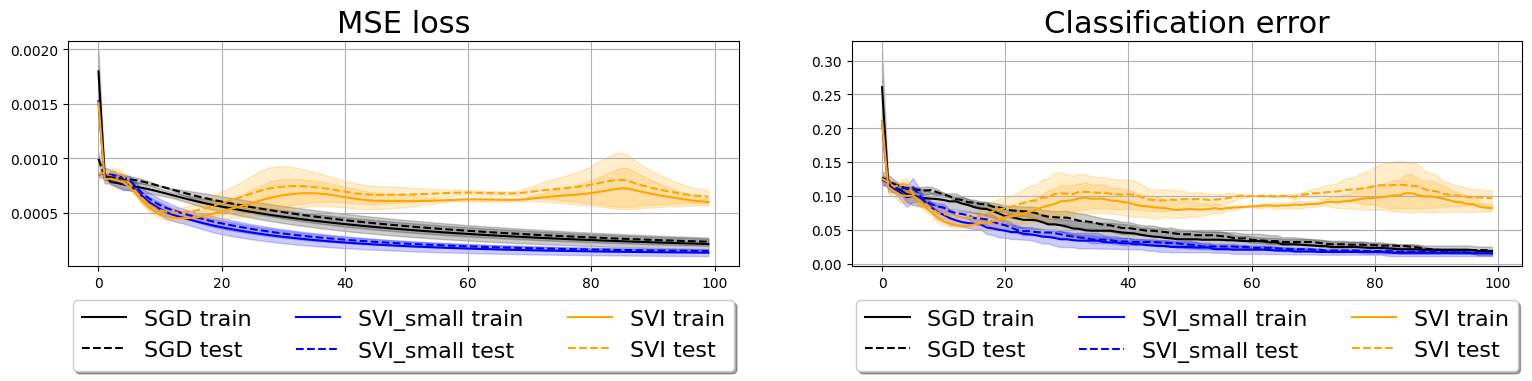

In [11]:
# Visualize results
ave_results_SGD = get_ave_results(results_final_dict_SGD)
ave_results_SVI_old = get_ave_results(results_final_dict_SVI_old)
ave_results_SVI_new = get_ave_results(results_final_dict_SVI_new)


# Plot losses and error
stop = 100
print(f'H = {H}, by epoch {stop} out of {epochs} epochs')
print('####################')
print(f'SGD train loss mean: {ave_results_SGD["train_loss"][stop-1]} +/- {ave_results_SGD["train_loss_std"][stop-1]}')
print(f'SVI_old train loss mean: {ave_results_SVI_old["train_loss"][stop-1]} +/- {ave_results_SVI_old["train_loss_std"][stop-1]}')
print(f'SVI train loss mean: {ave_results_SVI_new["train_loss"][stop-1]} +/- {ave_results_SVI_new["train_loss_std"][stop-1]}')
print('####################')
print(f'SGD test loss mean: {ave_results_SGD["test_loss"][stop-1]} +/- {ave_results_SGD["test_loss_std"][stop-1]}')
print(f'SVI_old test loss mean: {ave_results_SVI_old["test_loss"][stop-1]} +/- {ave_results_SVI_old["test_loss_std"][stop-1]}')
print(f'SVI test loss mean: {ave_results_SVI_new["test_loss"][stop-1]} +/- {ave_results_SVI_new["test_loss_std"][stop-1]}')
print('####################')
print(f'SGD train error mean: {1-ave_results_SGD["train_acc"][stop-1]} +/- {ave_results_SGD["train_acc_std"][stop-1]}')
print(f'SVI_old train error mean: {1-ave_results_SVI_old["train_acc"][stop-1]} +/- {ave_results_SVI_old["train_acc_std"][stop-1]}')
print(f'SVI train error mean: {1-ave_results_SVI_new["train_acc"][stop-1]} +/- {ave_results_SVI_new["train_acc_std"][stop-1]}')
print('####################')
print(f'SGD test error mean: {1-ave_results_SGD["test_acc"][stop-1]} +/- {ave_results_SGD["test_acc_std"][stop-1]}')
print(f'SVI_old test error mean: {1-ave_results_SVI_old["test_acc"][stop-1]} +/- {ave_results_SVI_old["test_acc_std"][stop-1]}')
print(f'SVI test error mean: {1-ave_results_SVI_new["test_acc"][stop-1]} +/- {ave_results_SVI_new["test_acc_std"][stop-1]}')

fig, ax = plt.subplots(1, 2, figsize=(16, 4))
fsize = 22
args = {'ax': ax[0]}
color_labels = {0: ['black', 'SGD'], 1: ['blue', 'SVI_small'], 2: ['orange', 'SVI']}
for i, ave_results in enumerate([ave_results_SGD, ave_results_SVI_old, ave_results_SVI_new]):
    train_key, test_key, suffix = 'train_loss', 'test_loss', '_std'
    args['color'], args['label'] = color_labels[i]
    plot_on_axes(ave_results[train_key][:stop], ave_results[train_key+suffix][:stop],
                 ave_results[test_key][:stop], ave_results[test_key+suffix][:stop],
                 args)
ax[0].set_title('MSE loss', fontsize=fsize)

args = {'ax': ax[1]}
for i, ave_results in enumerate([ave_results_SGD, ave_results_SVI_old, ave_results_SVI_new]):
    train_key, test_key, suffix = 'train_acc', 'test_acc', '_std'
    args['color'], args['label'] = color_labels[i]
    plot_on_axes(1-ave_results[train_key][:stop], ave_results[train_key+suffix][:stop],
                 1-ave_results[test_key][:stop], ave_results[test_key+suffix][:stop],
                 args)
ax[1].set_title('Classification error', fontsize=fsize)

for a in ax.flatten():
    a.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
                fancybox=True, shadow=True, ncol=3, fontsize=fsize-6)
    a.grid()
fig.tight_layout()
plt.show()

In [12]:
# # Plot changes in parameter norms
# fig, ax = plt.subplots(1, 2, figsize=(16, 4))
# fsize = 22
# args = {'ax': ax[0]}
# color_labels = {0: ['blue', 'SVI_small'], 1: ['orange', 'SVI']}
# for i, ave_results in enumerate([ave_results_SVI_old, ave_results_SVI_new]):
#     key, suffix = 'layer_1_norm', '_std'
#     args['color'], args['label'] = color_labels[i]
#     plot_on_axes_sub(ave_results[key][:stop], ave_results[key+suffix][:stop], args)
# ax[0].set_title('Layer 1 norm diff', fontsize=fsize)
# args = {'ax': ax[1]}
# for i, ave_results in enumerate([ave_results_SVI_old, ave_results_SVI_new]):
#     key, suffix = 'layer_2_norm', '_std'
#     args['color'], args['label'] = color_labels[i]
#     plot_on_axes_sub(ave_results[key][:stop], ave_results[key+suffix][:stop], args)
# ax[1].set_title('Layer 2 norm diff', fontsize=fsize)
# for a in ax.flatten():
#     a.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
#                 fancybox=True, shadow=True, ncol=3, fontsize=fsize-6)
#     a.grid()
# fig.tight_layout()
# plt.show()

### 64 hidden nodes

In [13]:
# Hyperparameters
random_states = [1103, 1111, 1214] # This coupled with `Variable` for SGD would get the same results as in paper
# random_states = [1103, 1111, 1214, 1228, 524]
H = 64
nlayers = 2
N = 1000
batch_size = int(N/10)
learning_rate = 0.15
momen = 0.9
epochs = 100

In [14]:
# SGD
results_final_dict_SGD = all_together(random_states, SGD = True, nlayers = nlayers)

SGD , H=64, random_state=1103
learning rate= 0.15 , train accuracy= 99.4 %, test accuracy= 99.4 %
training loss = 0.0001, test loss = 0.0002
SGD , H=64, random_state=1111
learning rate= 0.15 , train accuracy= 98.4 %, test accuracy= 98.2 %
training loss = 0.0002, test loss = 0.0002
SGD , H=64, random_state=1214
learning rate= 0.15 , train accuracy= 99.2 %, test accuracy= 99.2 %
training loss = 0.0001, test loss = 0.0002


In [15]:
# SVI old small scale
results_final_dict_SVI_old = all_together(random_states, SGD = False,
                                          small_prev_layer = True, nlayers = nlayers)

SVI old, H=64, random_state=1103
learning rate= 0.15 , train accuracy= 99.6 %, test accuracy= 99.4 %
training loss = 0.0001, test loss = 0.0001
SVI old, H=64, random_state=1111
learning rate= 0.15 , train accuracy= 99.0 %, test accuracy= 98.6 %
training loss = 0.0001, test loss = 0.0001
SVI old, H=64, random_state=1214
learning rate= 0.15 , train accuracy= 99.6 %, test accuracy= 99.2 %
training loss = 0.0001, test loss = 0.0001


In [16]:
# SVI new original scale
results_final_dict_SVI_new = all_together(random_states, SGD = False,
                                          small_prev_layer = False, nlayers = nlayers)

SVI new, H=64, random_state=1103
learning rate= 0.15 , train accuracy= 90.4 %, test accuracy= 88.4 %
training loss = 0.0007, test loss = 0.0008
SVI new, H=64, random_state=1111
learning rate= 0.15 , train accuracy= 90.8 %, test accuracy= 89.4 %
training loss = 0.0007, test loss = 0.0007
SVI new, H=64, random_state=1214
learning rate= 0.15 , train accuracy= 92.60000000000001 %, test accuracy= 91.8 %
training loss = 0.0006, test loss = 0.0006


H = 64, by epoch 100 out of 100 epochs
####################
SGD train loss mean: 0.0001606855792924762 +/- 2.9581586442496998e-05
SVI_old train loss mean: 7.637631722415486e-05 +/- 2.5725304233566815e-05
SVI train loss mean: 0.000674668992559115 +/- 4.820900673192396e-05
####################
SGD test loss mean: 0.0001779246131579081 +/- 2.0951697437437768e-05
SVI_old test loss mean: 8.775324498613676e-05 +/- 1.8417646720049468e-05
SVI test loss mean: 0.0007160501579443613 +/- 9.087840744639606e-05
####################
SGD train error mean: 0.01000000000000012 +/- 0.0043204937989385775
SVI_old train error mean: 0.005999999999999894 +/- 0.0028284271247461922
SVI train error mean: 0.08733333333333337 +/- 0.009568466729604892
####################
SGD test error mean: 0.010666666666666713 +/- 0.005249338582674546
SVI_old test error mean: 0.009333333333333305 +/- 0.003399346342395193
SVI test error mean: 0.10133333333333328 +/- 0.014267289706021811


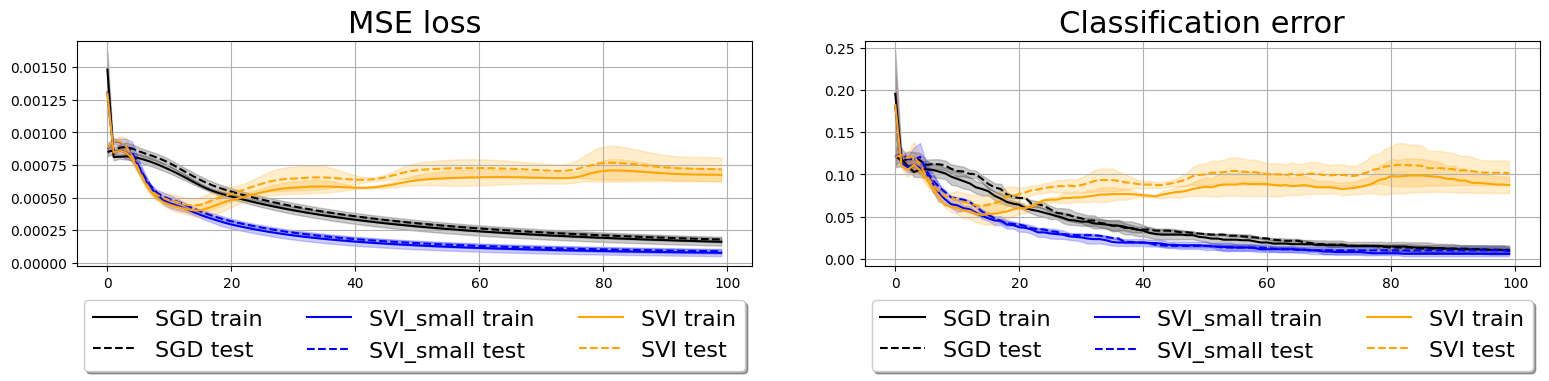

In [17]:
# Visualize results
ave_results_SGD = get_ave_results(results_final_dict_SGD)
ave_results_SVI_old = get_ave_results(results_final_dict_SVI_old)
ave_results_SVI_new = get_ave_results(results_final_dict_SVI_new)


# Plot losses and error
stop = 100
print(f'H = {H}, by epoch {stop} out of {epochs} epochs')
print('####################')
print(f'SGD train loss mean: {ave_results_SGD["train_loss"][stop-1]} +/- {ave_results_SGD["train_loss_std"][stop-1]}')
print(f'SVI_old train loss mean: {ave_results_SVI_old["train_loss"][stop-1]} +/- {ave_results_SVI_old["train_loss_std"][stop-1]}')
print(f'SVI train loss mean: {ave_results_SVI_new["train_loss"][stop-1]} +/- {ave_results_SVI_new["train_loss_std"][stop-1]}')
print('####################')
print(f'SGD test loss mean: {ave_results_SGD["test_loss"][stop-1]} +/- {ave_results_SGD["test_loss_std"][stop-1]}')
print(f'SVI_old test loss mean: {ave_results_SVI_old["test_loss"][stop-1]} +/- {ave_results_SVI_old["test_loss_std"][stop-1]}')
print(f'SVI test loss mean: {ave_results_SVI_new["test_loss"][stop-1]} +/- {ave_results_SVI_new["test_loss_std"][stop-1]}')
print('####################')
print(f'SGD train error mean: {1-ave_results_SGD["train_acc"][stop-1]} +/- {ave_results_SGD["train_acc_std"][stop-1]}')
print(f'SVI_old train error mean: {1-ave_results_SVI_old["train_acc"][stop-1]} +/- {ave_results_SVI_old["train_acc_std"][stop-1]}')
print(f'SVI train error mean: {1-ave_results_SVI_new["train_acc"][stop-1]} +/- {ave_results_SVI_new["train_acc_std"][stop-1]}')
print('####################')
print(f'SGD test error mean: {1-ave_results_SGD["test_acc"][stop-1]} +/- {ave_results_SGD["test_acc_std"][stop-1]}')
print(f'SVI_old test error mean: {1-ave_results_SVI_old["test_acc"][stop-1]} +/- {ave_results_SVI_old["test_acc_std"][stop-1]}')
print(f'SVI test error mean: {1-ave_results_SVI_new["test_acc"][stop-1]} +/- {ave_results_SVI_new["test_acc_std"][stop-1]}')

fig, ax = plt.subplots(1, 2, figsize=(16, 4))
fsize = 22
args = {'ax': ax[0]}
color_labels = {0: ['black', 'SGD'], 1: ['blue', 'SVI_small'], 2: ['orange', 'SVI']}
for i, ave_results in enumerate([ave_results_SGD, ave_results_SVI_old, ave_results_SVI_new]):
    train_key, test_key, suffix = 'train_loss', 'test_loss', '_std'
    args['color'], args['label'] = color_labels[i]
    plot_on_axes(ave_results[train_key][:stop], ave_results[train_key+suffix][:stop],
                 ave_results[test_key][:stop], ave_results[test_key+suffix][:stop],
                 args)
ax[0].set_title('MSE loss', fontsize=fsize)

args = {'ax': ax[1]}
for i, ave_results in enumerate([ave_results_SGD, ave_results_SVI_old, ave_results_SVI_new]):
    train_key, test_key, suffix = 'train_acc', 'test_acc', '_std'
    args['color'], args['label'] = color_labels[i]
    plot_on_axes(1-ave_results[train_key][:stop], ave_results[train_key+suffix][:stop],
                 1-ave_results[test_key][:stop], ave_results[test_key+suffix][:stop],
                 args)
ax[1].set_title('Classification error', fontsize=fsize)

for a in ax.flatten():
    a.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
                fancybox=True, shadow=True, ncol=3, fontsize=fsize-6)
    a.grid()
fig.tight_layout()
plt.show()

### 128 hidden nodes

In [18]:
# Hyperparameters
random_states = [1103, 1111, 1214] # This coupled with `Variable` for SGD would get the same results as in paper
# random_states = [1103, 1111, 1214, 1228, 524]
H = 128
nlayers = 2
N = 1000
batch_size = int(N/10)
learning_rate = 0.15
momen = 0.9
epochs = 100

In [19]:
# SGD
results_final_dict_SGD = all_together(random_states, SGD = True, nlayers = nlayers)

SGD , H=128, random_state=1103
learning rate= 0.15 , train accuracy= 99.8 %, test accuracy= 99.6 %
training loss = 0.0001, test loss = 0.0001
SGD , H=128, random_state=1111
learning rate= 0.15 , train accuracy= 99.2 %, test accuracy= 99.4 %
training loss = 0.0001, test loss = 0.0001
SGD , H=128, random_state=1214
learning rate= 0.15 , train accuracy= 99.6 %, test accuracy= 99.2 %
training loss = 0.0001, test loss = 0.0001


In [20]:
# SVI old small scale
results_final_dict_SVI_old = all_together(random_states, SGD = False,
                                          small_prev_layer = True, nlayers = nlayers)

SVI old, H=128, random_state=1103
learning rate= 0.15 , train accuracy= 99.8 %, test accuracy= 99.6 %
training loss = 0.0000, test loss = 0.0000
SVI old, H=128, random_state=1111
learning rate= 0.15 , train accuracy= 99.2 %, test accuracy= 99.6 %
training loss = 0.0001, test loss = 0.0000
SVI old, H=128, random_state=1214
learning rate= 0.15 , train accuracy= 99.6 %, test accuracy= 99.4 %
training loss = 0.0000, test loss = 0.0000


In [21]:
# SVI new original scale
results_final_dict_SVI_new = all_together(random_states, SGD = False,
                                          small_prev_layer = False, nlayers = nlayers)

SVI new, H=128, random_state=1103
learning rate= 0.15 , train accuracy= 87.6 %, test accuracy= 85.2 %
training loss = 0.0008, test loss = 0.0009
SVI new, H=128, random_state=1111
learning rate= 0.15 , train accuracy= 96.8 %, test accuracy= 97.6 %
training loss = 0.0003, test loss = 0.0003
SVI new, H=128, random_state=1214
learning rate= 0.15 , train accuracy= 92.60000000000001 %, test accuracy= 91.8 %
training loss = 0.0006, test loss = 0.0006


H = 128, by epoch 100 out of 100 epochs
####################
SGD train loss mean: 8.32637194544077e-05 +/- 1.6282551060219585e-05
SVI_old train loss mean: 3.670076773657153e-05 +/- 1.0720644568533805e-05
SVI train loss mean: 0.0005706117389102776 +/- 0.00018064720762319013
####################
SGD test loss mean: 9.08085652627051e-05 +/- 1.8756264046865757e-05
SVI_old test loss mean: 4.013138830972215e-05 +/- 9.71767803635642e-06
SVI test loss mean: 0.0006011556374529997 +/- 0.00023210912718043606
####################
SGD train error mean: 0.004666666666666708 +/- 0.0024944382578492965
SVI_old train error mean: 0.004666666666666708 +/- 0.0024944382578492965
SVI train error mean: 0.07666666666666666 +/- 0.03760614606978787
####################
SGD test error mean: 0.005999999999999894 +/- 0.0016329931618554536
SVI_old test error mean: 0.004666666666666708 +/- 0.0009428090415820641
SVI test error mean: 0.08466666666666667 +/- 0.050657893977367655


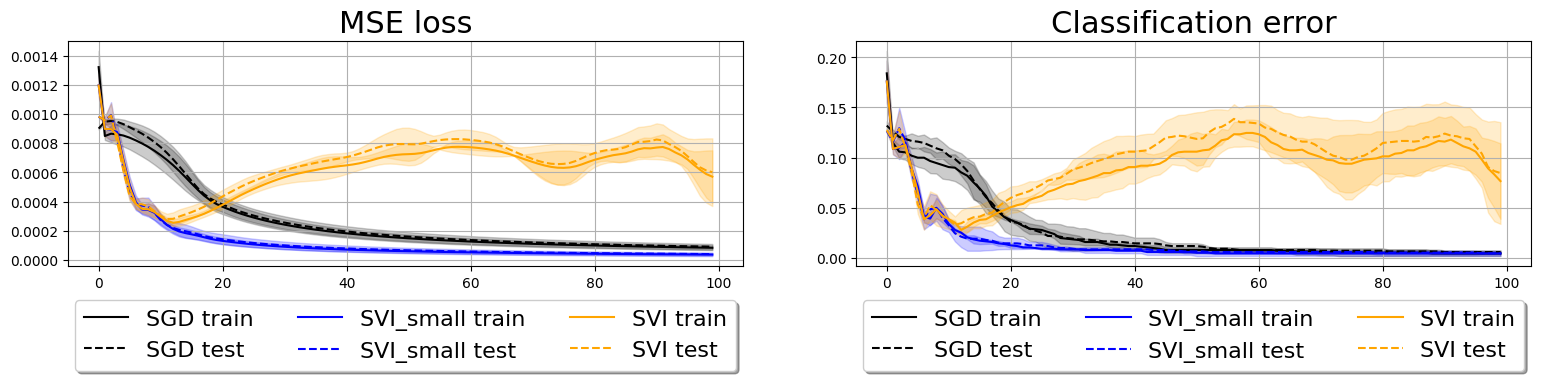

In [22]:
# Visualize results
ave_results_SGD = get_ave_results(results_final_dict_SGD)
ave_results_SVI_old = get_ave_results(results_final_dict_SVI_old)
ave_results_SVI_new = get_ave_results(results_final_dict_SVI_new)


# Plot losses and error
stop = 100
print(f'H = {H}, by epoch {stop} out of {epochs} epochs')
print('####################')
print(f'SGD train loss mean: {ave_results_SGD["train_loss"][stop-1]} +/- {ave_results_SGD["train_loss_std"][stop-1]}')
print(f'SVI_old train loss mean: {ave_results_SVI_old["train_loss"][stop-1]} +/- {ave_results_SVI_old["train_loss_std"][stop-1]}')
print(f'SVI train loss mean: {ave_results_SVI_new["train_loss"][stop-1]} +/- {ave_results_SVI_new["train_loss_std"][stop-1]}')
print('####################')
print(f'SGD test loss mean: {ave_results_SGD["test_loss"][stop-1]} +/- {ave_results_SGD["test_loss_std"][stop-1]}')
print(f'SVI_old test loss mean: {ave_results_SVI_old["test_loss"][stop-1]} +/- {ave_results_SVI_old["test_loss_std"][stop-1]}')
print(f'SVI test loss mean: {ave_results_SVI_new["test_loss"][stop-1]} +/- {ave_results_SVI_new["test_loss_std"][stop-1]}')
print('####################')
print(f'SGD train error mean: {1-ave_results_SGD["train_acc"][stop-1]} +/- {ave_results_SGD["train_acc_std"][stop-1]}')
print(f'SVI_old train error mean: {1-ave_results_SVI_old["train_acc"][stop-1]} +/- {ave_results_SVI_old["train_acc_std"][stop-1]}')
print(f'SVI train error mean: {1-ave_results_SVI_new["train_acc"][stop-1]} +/- {ave_results_SVI_new["train_acc_std"][stop-1]}')
print('####################')
print(f'SGD test error mean: {1-ave_results_SGD["test_acc"][stop-1]} +/- {ave_results_SGD["test_acc_std"][stop-1]}')
print(f'SVI_old test error mean: {1-ave_results_SVI_old["test_acc"][stop-1]} +/- {ave_results_SVI_old["test_acc_std"][stop-1]}')
print(f'SVI test error mean: {1-ave_results_SVI_new["test_acc"][stop-1]} +/- {ave_results_SVI_new["test_acc_std"][stop-1]}')

fig, ax = plt.subplots(1, 2, figsize=(16, 4))
fsize = 22
args = {'ax': ax[0]}
color_labels = {0: ['black', 'SGD'], 1: ['blue', 'SVI_small'], 2: ['orange', 'SVI']}
for i, ave_results in enumerate([ave_results_SGD, ave_results_SVI_old, ave_results_SVI_new]):
    train_key, test_key, suffix = 'train_loss', 'test_loss', '_std'
    args['color'], args['label'] = color_labels[i]
    plot_on_axes(ave_results[train_key][:stop], ave_results[train_key+suffix][:stop],
                 ave_results[test_key][:stop], ave_results[test_key+suffix][:stop],
                 args)
ax[0].set_title('MSE loss', fontsize=fsize)

args = {'ax': ax[1]}
for i, ave_results in enumerate([ave_results_SGD, ave_results_SVI_old, ave_results_SVI_new]):
    train_key, test_key, suffix = 'train_acc', 'test_acc', '_std'
    args['color'], args['label'] = color_labels[i]
    plot_on_axes(1-ave_results[train_key][:stop], ave_results[train_key+suffix][:stop],
                 1-ave_results[test_key][:stop], ave_results[test_key+suffix][:stop],
                 args)
ax[1].set_title('Classification error', fontsize=fsize)

for a in ax.flatten():
    a.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
                fancybox=True, shadow=True, ncol=3, fontsize=fsize-6)
    a.grid()
fig.tight_layout()
plt.show()

### 256 hidden nodes

In [23]:
# Hyperparameters
random_states = [1103, 1111, 1214] # This coupled with `Variable` for SGD would get the same results as in paper
# random_states = [1103, 1111, 1214, 1228, 524]
H = 256
nlayers = 2
N = 1000
batch_size = int(N/10)
learning_rate = 0.15
momen = 0.9
epochs = 100

In [24]:
# SGD
results_final_dict_SGD = all_together(random_states, SGD = True, nlayers = nlayers)

SGD , H=256, random_state=1103
learning rate= 0.15 , train accuracy= 99.8 %, test accuracy= 100.0 %
training loss = 0.0000, test loss = 0.0000
SGD , H=256, random_state=1111
learning rate= 0.15 , train accuracy= 99.2 %, test accuracy= 99.6 %
training loss = 0.0001, test loss = 0.0001
SGD , H=256, random_state=1214
learning rate= 0.15 , train accuracy= 99.6 %, test accuracy= 99.6 %
training loss = 0.0000, test loss = 0.0000


In [25]:
# SVI old small scale
results_final_dict_SVI_old = all_together(random_states, SGD = False,
                                          small_prev_layer = True, nlayers = nlayers)

SVI old, H=256, random_state=1103
learning rate= 0.15 , train accuracy= 99.8 %, test accuracy= 100.0 %
training loss = 0.0000, test loss = 0.0000
SVI old, H=256, random_state=1111
learning rate= 0.15 , train accuracy= 99.6 %, test accuracy= 99.8 %
training loss = 0.0000, test loss = 0.0000
SVI old, H=256, random_state=1214
learning rate= 0.15 , train accuracy= 99.6 %, test accuracy= 99.8 %
training loss = 0.0000, test loss = 0.0000


In [26]:
# SVI new original scale
results_final_dict_SVI_new = all_together(random_states, SGD = False,
                                          small_prev_layer = False, nlayers = nlayers)

SVI new, H=256, random_state=1103
learning rate= 0.15 , train accuracy= 90.0 %, test accuracy= 88.4 %
training loss = 0.0007, test loss = 0.0008
SVI new, H=256, random_state=1111
learning rate= 0.15 , train accuracy= 98.2 %, test accuracy= 98.0 %
training loss = 0.0003, test loss = 0.0003
SVI new, H=256, random_state=1214
learning rate= 0.15 , train accuracy= 94.8 %, test accuracy= 92.60000000000001 %
training loss = 0.0004, test loss = 0.0005


H = 256, by epoch 100 out of 100 epochs
####################
SGD train loss mean: 4.867443884722888e-05 +/- 1.462477715374561e-05
SVI_old train loss mean: 1.9980739035721246e-05 +/- 9.341266205308588e-06
SVI train loss mean: 0.0004592396033306916 +/- 0.0001684325470503207
####################
SGD test loss mean: 5.3609629782537624e-05 +/- 1.0612032706174304e-05
SVI_old test loss mean: 2.218486877973191e-05 +/- 7.890155328065425e-06
SVI test loss mean: 0.0005197442745169004 +/- 0.00019792469330826373
####################
SGD train error mean: 0.004666666666666708 +/- 0.0024944382578492965
SVI_old train error mean: 0.0033333333333332993 +/- 0.0009428090415820641
SVI train error mean: 0.05666666666666664 +/- 0.03363860216411429
####################
SGD test error mean: 0.002666666666666706 +/- 0.0018856180831641283
SVI_old test error mean: 0.0013333333333332975 +/- 0.0009428090415820641
SVI test error mean: 0.06999999999999995 +/- 0.03929376540877699


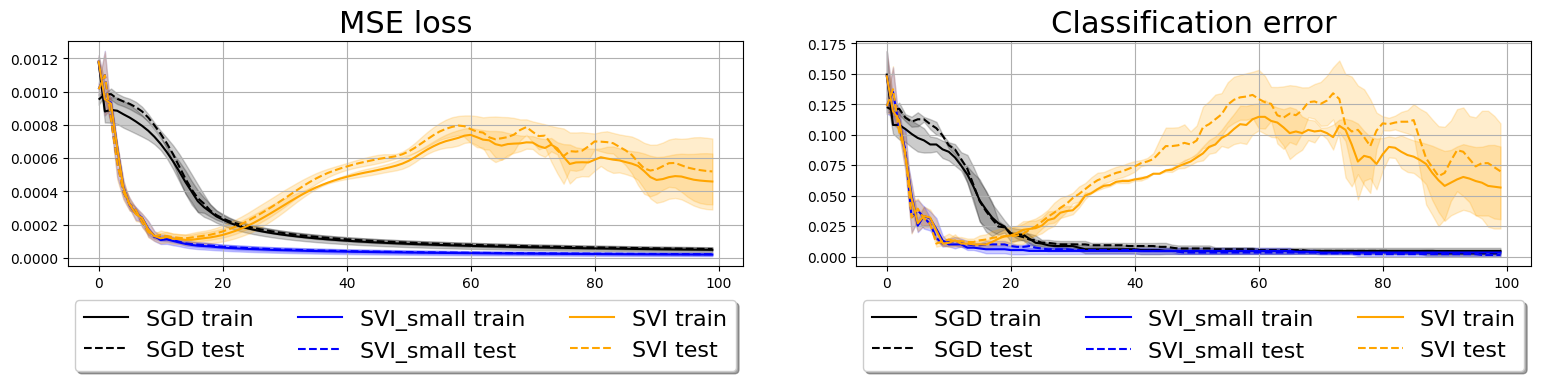

In [27]:
# Visualize results
ave_results_SGD = get_ave_results(results_final_dict_SGD)
ave_results_SVI_old = get_ave_results(results_final_dict_SVI_old)
ave_results_SVI_new = get_ave_results(results_final_dict_SVI_new)


# Plot losses and error
stop = 100
print(f'H = {H}, by epoch {stop} out of {epochs} epochs')
print('####################')
print(f'SGD train loss mean: {ave_results_SGD["train_loss"][stop-1]} +/- {ave_results_SGD["train_loss_std"][stop-1]}')
print(f'SVI_old train loss mean: {ave_results_SVI_old["train_loss"][stop-1]} +/- {ave_results_SVI_old["train_loss_std"][stop-1]}')
print(f'SVI train loss mean: {ave_results_SVI_new["train_loss"][stop-1]} +/- {ave_results_SVI_new["train_loss_std"][stop-1]}')
print('####################')
print(f'SGD test loss mean: {ave_results_SGD["test_loss"][stop-1]} +/- {ave_results_SGD["test_loss_std"][stop-1]}')
print(f'SVI_old test loss mean: {ave_results_SVI_old["test_loss"][stop-1]} +/- {ave_results_SVI_old["test_loss_std"][stop-1]}')
print(f'SVI test loss mean: {ave_results_SVI_new["test_loss"][stop-1]} +/- {ave_results_SVI_new["test_loss_std"][stop-1]}')
print('####################')
print(f'SGD train error mean: {1-ave_results_SGD["train_acc"][stop-1]} +/- {ave_results_SGD["train_acc_std"][stop-1]}')
print(f'SVI_old train error mean: {1-ave_results_SVI_old["train_acc"][stop-1]} +/- {ave_results_SVI_old["train_acc_std"][stop-1]}')
print(f'SVI train error mean: {1-ave_results_SVI_new["train_acc"][stop-1]} +/- {ave_results_SVI_new["train_acc_std"][stop-1]}')
print('####################')
print(f'SGD test error mean: {1-ave_results_SGD["test_acc"][stop-1]} +/- {ave_results_SGD["test_acc_std"][stop-1]}')
print(f'SVI_old test error mean: {1-ave_results_SVI_old["test_acc"][stop-1]} +/- {ave_results_SVI_old["test_acc_std"][stop-1]}')
print(f'SVI test error mean: {1-ave_results_SVI_new["test_acc"][stop-1]} +/- {ave_results_SVI_new["test_acc_std"][stop-1]}')

fig, ax = plt.subplots(1, 2, figsize=(16, 4))
fsize = 22
args = {'ax': ax[0]}
color_labels = {0: ['black', 'SGD'], 1: ['blue', 'SVI_small'], 2: ['orange', 'SVI']}
for i, ave_results in enumerate([ave_results_SGD, ave_results_SVI_old, ave_results_SVI_new]):
    train_key, test_key, suffix = 'train_loss', 'test_loss', '_std'
    args['color'], args['label'] = color_labels[i]
    plot_on_axes(ave_results[train_key][:stop], ave_results[train_key+suffix][:stop],
                 ave_results[test_key][:stop], ave_results[test_key+suffix][:stop],
                 args)
ax[0].set_title('MSE loss', fontsize=fsize)

args = {'ax': ax[1]}
for i, ave_results in enumerate([ave_results_SGD, ave_results_SVI_old, ave_results_SVI_new]):
    train_key, test_key, suffix = 'train_acc', 'test_acc', '_std'
    args['color'], args['label'] = color_labels[i]
    plot_on_axes(1-ave_results[train_key][:stop], ave_results[train_key+suffix][:stop],
                 1-ave_results[test_key][:stop], ave_results[test_key+suffix][:stop],
                 args)
ax[1].set_title('Classification error', fontsize=fsize)

for a in ax.flatten():
    a.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
                fancybox=True, shadow=True, ncol=3, fontsize=fsize-6)
    a.grid()
fig.tight_layout()
plt.show()

## Three layer

In [6]:
class three_moon_net(nn.Module):
    def __init__(self, H):
        super().__init__()
        self.convs = torch.nn.ModuleList()
        self.convs.append(nn.Linear(2, H))
        self.convs.append(nn.Linear(H, H))
        self.convs.append(nn.Linear(H, 2))

    def forward(self, x):
        x = F.relu(self.convs[0](x)) 
        self.layer1_x = Variable(x, requires_grad=True)
        layer2_x = F.relu(self.convs[1](self.layer1_x))
        layer3_x = self.convs[2](layer2_x)
        return F.softmax(layer3_x, dim=1)


class three_moon_net_SVI(nn.Module):
    def __init__(self, H):
        super().__init__()
        self.convs = torch.nn.ModuleList()
        self.convs.append(nn.Linear(2, H))
        self.convs.append(nn.Linear(H, H))
        self.convs.append(nn.Linear(H, 2))

        #### New lines for SVI ####
        # If any layer true, then it needs to use SVI
        self.layers_with_SVI = [True for i in range(len(self.convs))]
        # Append pre-activation \tilde{X}_{l+1}, ONLY at layers i where self.layers_with_SVI[i] == True
        self.layers_Xtilde = []
        # Append the grad of L w.r.t. X_{l+1}, ONLY at layers i where self.layers_with_SVI[i] == True
        self.layers_grad = []
        self.on_training = True
        #### End #####

    #### New lines for SVI ####
    # Avoid gradient accumulation
    def turn_on_off_grad(self, on = True):
        for param in self.parameters():
            param.requires_grad = on
    #### End #####

    def forward(self, x):
        for i, conv in enumerate(self.convs):
            #### New lines for SVI ####
            # This is added b/c o/w the gradient backprop w.r.t. new loss also gets to earlier layers (undesirable)
            if self.layers_with_SVI[i] and self.on_training:
                x_tmp = x.detach().clone().to(device)
                self.layers_Xtilde.append(conv(x_tmp))
            #### End #####
            x = conv(x)
            if i < len(self.convs) - 1:
                x = F.relu(x)
            else:
                x = F.softmax(x, dim=1)
            #### New lines for SVI ####
            if self.layers_with_SVI[i] and self.on_training:
                x.retain_grad()  # To get the gradient with respect to output
                self.layers_grad.append(x)
            #### End #####
        return x
    
def check_layer_grad(model):
    for name, param in model.named_parameters():
        if param.grad is not None:
            print(name, param.grad.norm())

def check_init_norm(model):
    print("#### Initial norm of parameters: ")
    for name, param in model.named_parameters():
        print(name, param.norm())

### 32 hidden nodes

In [38]:
# Hyperparameters
random_states = [12314,31231224,12341]
H = 32
nlayers = 3
N = 1000
batch_size = int(N/10)
learning_rate = 0.15
momen = 0.9
epochs = 100

In [39]:
# SGD
results_final_dict_SGD = all_together(random_states, SGD = True, nlayers = nlayers)

SGD , H=32, random_state=12314
learning rate= 0.15 , train accuracy= 100.0 %, test accuracy= 99.8 %
training loss = 0.0000, test loss = 0.0000
SGD , H=32, random_state=31231224
learning rate= 0.15 , train accuracy= 99.8 %, test accuracy= 99.6 %
training loss = 0.0000, test loss = 0.0000
SGD , H=32, random_state=12341
learning rate= 0.15 , train accuracy= 100.0 %, test accuracy= 99.6 %
training loss = 0.0000, test loss = 0.0001


In [40]:
# SVI old small scale
results_final_dict_SVI_old = all_together(random_states, SGD = False,
                                          small_prev_layer = True, nlayers = nlayers)

SVI old, H=32, random_state=12314
learning rate= 0.15 , train accuracy= 97.6 %, test accuracy= 96.2 %
training loss = 0.0002, test loss = 0.0003
SVI old, H=32, random_state=31231224
learning rate= 0.15 , train accuracy= 97.0 %, test accuracy= 97.39999999999999 %
training loss = 0.0002, test loss = 0.0003
SVI old, H=32, random_state=12341
learning rate= 0.15 , train accuracy= 96.6 %, test accuracy= 93.0 %
training loss = 0.0003, test loss = 0.0005


In [41]:
# SVI new original scale
results_final_dict_SVI_new = all_together(random_states, SGD = False,
                                          small_prev_layer = False, nlayers = nlayers)

SVI new, H=32, random_state=12314
learning rate= 0.15 , train accuracy= 99.8 %, test accuracy= 99.8 %
training loss = 0.0000, test loss = 0.0000
SVI new, H=32, random_state=31231224
learning rate= 0.15 , train accuracy= 99.6 %, test accuracy= 99.6 %
training loss = 0.0000, test loss = 0.0000
SVI new, H=32, random_state=12341
learning rate= 0.15 , train accuracy= 88.4 %, test accuracy= 87.8 %
training loss = 0.0007, test loss = 0.0010


H = 32, by epoch 5 out of 100 epochs
####################
SGD train loss mean: 0.0008129386206467947 +/- 3.423118649369947e-05
SVI_old train loss mean: 0.0008711546187599499 +/- 8.543928238155566e-05
SVI train loss mean: 0.0008340168346961339 +/- 2.60189344780724e-05
####################
SGD test loss mean: 0.0008449137533704439 +/- 0.00011109132867074435
SVI_old test loss mean: 0.0008825938800970714 +/- 0.00016366953578479608
SVI test loss mean: 0.0008849912807345391 +/- 0.0001390638406616673
####################
SGD train error mean: 0.11399999999999999 +/- 0.005887840577551903
SVI_old train error mean: 0.1213333333333333 +/- 0.016357125528513743
SVI train error mean: 0.10933333333333328 +/- 0.003399346342395193
####################
SGD test error mean: 0.11199999999999999 +/- 0.016083117442419772
SVI_old test error mean: 0.1213333333333333 +/- 0.024783507060588163
SVI test error mean: 0.11599999999999999 +/- 0.014966629547095779


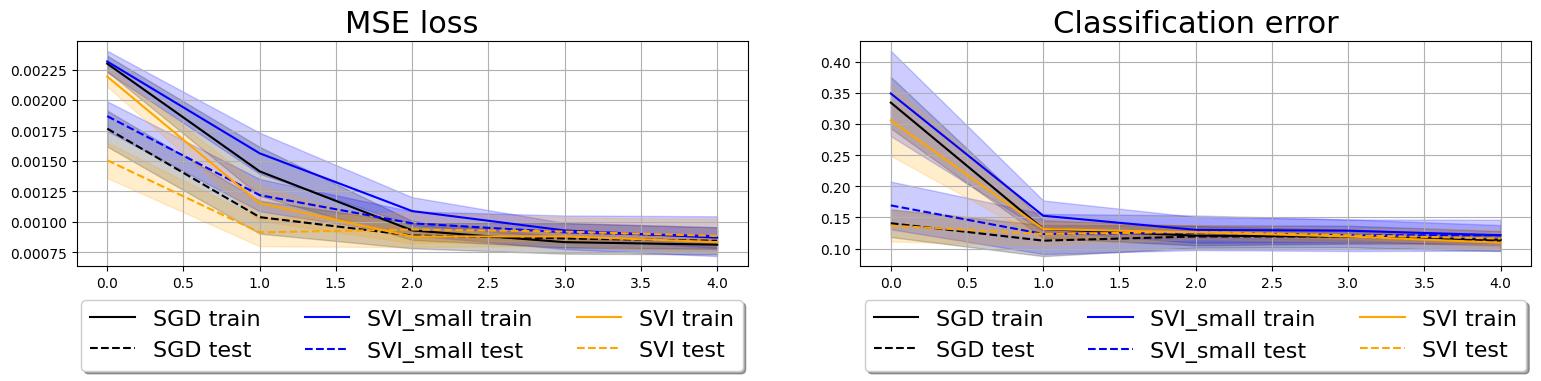

In [42]:
# Visualize results
ave_results_SGD = get_ave_results(results_final_dict_SGD)
ave_results_SVI_old = get_ave_results(results_final_dict_SVI_old)
ave_results_SVI_new = get_ave_results(results_final_dict_SVI_new)


# Plot losses and error
stop = 5
print(f'H = {H}, by epoch {stop} out of {epochs} epochs')
print('####################')
print(f'SGD train loss mean: {ave_results_SGD["train_loss"][stop-1]} +/- {ave_results_SGD["train_loss_std"][stop-1]}')
print(f'SVI_old train loss mean: {ave_results_SVI_old["train_loss"][stop-1]} +/- {ave_results_SVI_old["train_loss_std"][stop-1]}')
print(f'SVI train loss mean: {ave_results_SVI_new["train_loss"][stop-1]} +/- {ave_results_SVI_new["train_loss_std"][stop-1]}')
print('####################')
print(f'SGD test loss mean: {ave_results_SGD["test_loss"][stop-1]} +/- {ave_results_SGD["test_loss_std"][stop-1]}')
print(f'SVI_old test loss mean: {ave_results_SVI_old["test_loss"][stop-1]} +/- {ave_results_SVI_old["test_loss_std"][stop-1]}')
print(f'SVI test loss mean: {ave_results_SVI_new["test_loss"][stop-1]} +/- {ave_results_SVI_new["test_loss_std"][stop-1]}')
print('####################')
print(f'SGD train error mean: {1-ave_results_SGD["train_acc"][stop-1]} +/- {ave_results_SGD["train_acc_std"][stop-1]}')
print(f'SVI_old train error mean: {1-ave_results_SVI_old["train_acc"][stop-1]} +/- {ave_results_SVI_old["train_acc_std"][stop-1]}')
print(f'SVI train error mean: {1-ave_results_SVI_new["train_acc"][stop-1]} +/- {ave_results_SVI_new["train_acc_std"][stop-1]}')
print('####################')
print(f'SGD test error mean: {1-ave_results_SGD["test_acc"][stop-1]} +/- {ave_results_SGD["test_acc_std"][stop-1]}')
print(f'SVI_old test error mean: {1-ave_results_SVI_old["test_acc"][stop-1]} +/- {ave_results_SVI_old["test_acc_std"][stop-1]}')
print(f'SVI test error mean: {1-ave_results_SVI_new["test_acc"][stop-1]} +/- {ave_results_SVI_new["test_acc_std"][stop-1]}')

fig, ax = plt.subplots(1, 2, figsize=(16, 4))
fsize = 22
args = {'ax': ax[0]}
color_labels = {0: ['black', 'SGD'], 1: ['blue', 'SVI_small'], 2: ['orange', 'SVI']}
for i, ave_results in enumerate([ave_results_SGD, ave_results_SVI_old, ave_results_SVI_new]):
    train_key, test_key, suffix = 'train_loss', 'test_loss', '_std'
    args['color'], args['label'] = color_labels[i]
    plot_on_axes(ave_results[train_key][:stop], ave_results[train_key+suffix][:stop],
                 ave_results[test_key][:stop], ave_results[test_key+suffix][:stop],
                 args)
ax[0].set_title('MSE loss', fontsize=fsize)

args = {'ax': ax[1]}
for i, ave_results in enumerate([ave_results_SGD, ave_results_SVI_old, ave_results_SVI_new]):
    train_key, test_key, suffix = 'train_acc', 'test_acc', '_std'
    args['color'], args['label'] = color_labels[i]
    plot_on_axes(1-ave_results[train_key][:stop], ave_results[train_key+suffix][:stop],
                 1-ave_results[test_key][:stop], ave_results[test_key+suffix][:stop],
                 args)
ax[1].set_title('Classification error', fontsize=fsize)

for a in ax.flatten():
    a.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
                fancybox=True, shadow=True, ncol=3, fontsize=fsize-6)
    a.grid()
fig.tight_layout()
plt.show()

H = 32, by epoch 100 out of 100 epochs
####################
SGD train loss mean: 1.9456791536261636e-05 +/- 6.71323674747829e-06
SVI_old train loss mean: 0.0002694716366628806 +/- 3.5246702164641895e-05
SVI train loss mean: 0.0002637966554708934 +/- 0.0003369983632283881
####################
SGD test loss mean: 4.441507979451368e-05 +/- 6.981355626134578e-06
SVI_old test loss mean: 0.0003474505171179771 +/- 9.007447928661604e-05
SVI test loss mean: 0.0003323025708765878 +/- 0.0004377733367990813
####################
SGD train error mean: 0.0006666666666665932 +/- 0.0009428090415820641
SVI_old train error mean: 0.029333333333333322 +/- 0.0041096093353126546
SVI train error mean: 0.04066666666666663 +/- 0.05327496806401879
####################
SGD test error mean: 0.0033333333333332993 +/- 0.0009428090415820641
SVI_old test error mean: 0.04466666666666663 +/- 0.018571184369578792
SVI test error mean: 0.04266666666666674 +/- 0.05610307973325132


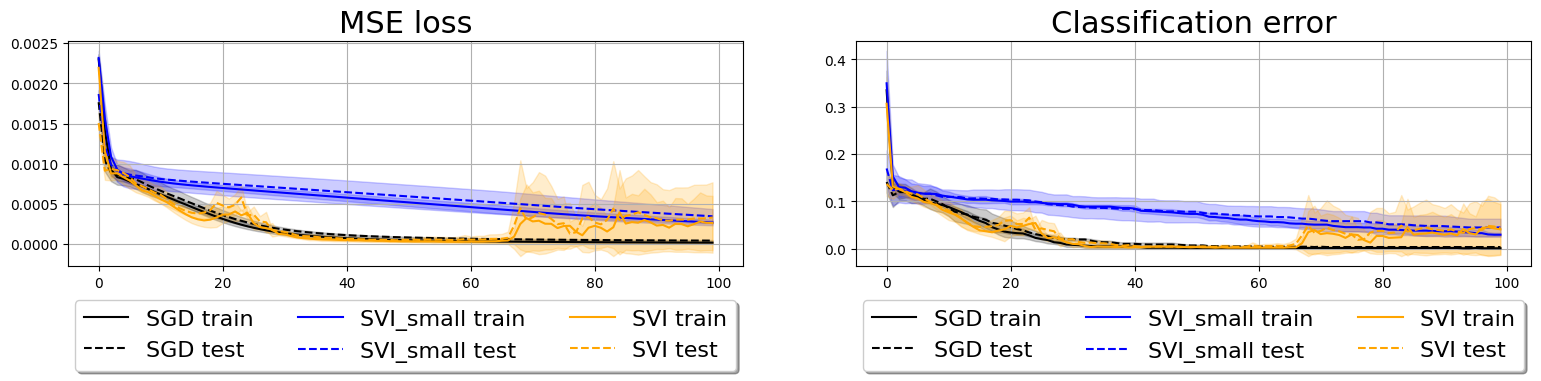

In [43]:
# Visualize results
ave_results_SGD = get_ave_results(results_final_dict_SGD)
ave_results_SVI_old = get_ave_results(results_final_dict_SVI_old)
ave_results_SVI_new = get_ave_results(results_final_dict_SVI_new)


# Plot losses and error
stop = 100
print(f'H = {H}, by epoch {stop} out of {epochs} epochs')
print('####################')
print(f'SGD train loss mean: {ave_results_SGD["train_loss"][stop-1]} +/- {ave_results_SGD["train_loss_std"][stop-1]}')
print(f'SVI_old train loss mean: {ave_results_SVI_old["train_loss"][stop-1]} +/- {ave_results_SVI_old["train_loss_std"][stop-1]}')
print(f'SVI train loss mean: {ave_results_SVI_new["train_loss"][stop-1]} +/- {ave_results_SVI_new["train_loss_std"][stop-1]}')
print('####################')
print(f'SGD test loss mean: {ave_results_SGD["test_loss"][stop-1]} +/- {ave_results_SGD["test_loss_std"][stop-1]}')
print(f'SVI_old test loss mean: {ave_results_SVI_old["test_loss"][stop-1]} +/- {ave_results_SVI_old["test_loss_std"][stop-1]}')
print(f'SVI test loss mean: {ave_results_SVI_new["test_loss"][stop-1]} +/- {ave_results_SVI_new["test_loss_std"][stop-1]}')
print('####################')
print(f'SGD train error mean: {1-ave_results_SGD["train_acc"][stop-1]} +/- {ave_results_SGD["train_acc_std"][stop-1]}')
print(f'SVI_old train error mean: {1-ave_results_SVI_old["train_acc"][stop-1]} +/- {ave_results_SVI_old["train_acc_std"][stop-1]}')
print(f'SVI train error mean: {1-ave_results_SVI_new["train_acc"][stop-1]} +/- {ave_results_SVI_new["train_acc_std"][stop-1]}')
print('####################')
print(f'SGD test error mean: {1-ave_results_SGD["test_acc"][stop-1]} +/- {ave_results_SGD["test_acc_std"][stop-1]}')
print(f'SVI_old test error mean: {1-ave_results_SVI_old["test_acc"][stop-1]} +/- {ave_results_SVI_old["test_acc_std"][stop-1]}')
print(f'SVI test error mean: {1-ave_results_SVI_new["test_acc"][stop-1]} +/- {ave_results_SVI_new["test_acc_std"][stop-1]}')

fig, ax = plt.subplots(1, 2, figsize=(16, 4))
fsize = 22
args = {'ax': ax[0]}
color_labels = {0: ['black', 'SGD'], 1: ['blue', 'SVI_small'], 2: ['orange', 'SVI']}
for i, ave_results in enumerate([ave_results_SGD, ave_results_SVI_old, ave_results_SVI_new]):
    train_key, test_key, suffix = 'train_loss', 'test_loss', '_std'
    args['color'], args['label'] = color_labels[i]
    plot_on_axes(ave_results[train_key][:stop], ave_results[train_key+suffix][:stop],
                 ave_results[test_key][:stop], ave_results[test_key+suffix][:stop],
                 args)
ax[0].set_title('MSE loss', fontsize=fsize)

args = {'ax': ax[1]}
for i, ave_results in enumerate([ave_results_SGD, ave_results_SVI_old, ave_results_SVI_new]):
    train_key, test_key, suffix = 'train_acc', 'test_acc', '_std'
    args['color'], args['label'] = color_labels[i]
    plot_on_axes(1-ave_results[train_key][:stop], ave_results[train_key+suffix][:stop],
                 1-ave_results[test_key][:stop], ave_results[test_key+suffix][:stop],
                 args)
ax[1].set_title('Classification error', fontsize=fsize)

for a in ax.flatten():
    a.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
                fancybox=True, shadow=True, ncol=3, fontsize=fsize-6)
    a.grid()
fig.tight_layout()
plt.show()

### 64 hidden nodes

In [13]:
# Hyperparameters
random_states = [12314,31231224,12341]
H = 64
nlayers = 3
N = 1000
batch_size = int(N/10)
learning_rate = 0.15
momen = 0.9
epochs = 100

In [14]:
# SGD
results_final_dict_SGD = all_together(random_states, SGD = True, nlayers = nlayers)

SGD , H=64, random_state=12314
learning rate= 0.15 , train accuracy= 99.8 %, test accuracy= 99.8 %
training loss = 0.0000, test loss = 0.0000
SGD , H=64, random_state=31231224
learning rate= 0.15 , train accuracy= 99.8 %, test accuracy= 99.8 %
training loss = 0.0000, test loss = 0.0000
SGD , H=64, random_state=12341
learning rate= 0.15 , train accuracy= 100.0 %, test accuracy= 99.6 %
training loss = 0.0000, test loss = 0.0000


In [15]:
# SVI old small scale
results_final_dict_SVI_old = all_together(random_states, SGD = False,
                                          small_prev_layer = True, nlayers = nlayers)

SVI old, H=64, random_state=12314
learning rate= 0.15 , train accuracy= 98.6 %, test accuracy= 96.8 %
training loss = 0.0002, test loss = 0.0003
SVI old, H=64, random_state=31231224
learning rate= 0.15 , train accuracy= 95.8 %, test accuracy= 96.0 %
training loss = 0.0003, test loss = 0.0003
SVI old, H=64, random_state=12341
learning rate= 0.15 , train accuracy= 97.8 %, test accuracy= 95.8 %
training loss = 0.0002, test loss = 0.0003


In [16]:
# SVI new original scale
results_final_dict_SVI_new = all_together(random_states, SGD = False,
                                          small_prev_layer = False, nlayers = nlayers)

SVI new, H=64, random_state=12314
learning rate= 0.15 , train accuracy= 99.6 %, test accuracy= 99.2 %
training loss = 0.0000, test loss = 0.0001
SVI new, H=64, random_state=31231224
learning rate= 0.15 , train accuracy= 99.8 %, test accuracy= 99.6 %
training loss = 0.0000, test loss = 0.0000
SVI new, H=64, random_state=12341
learning rate= 0.15 , train accuracy= 100.0 %, test accuracy= 99.8 %
training loss = 0.0000, test loss = 0.0000


H = 64, by epoch 5 out of 100 epochs
####################
SGD train loss mean: 0.0007757012695074082 +/- 2.3883495106633725e-05
SVI_old train loss mean: 0.000787254773080349 +/- 4.739155831194959e-05
SVI train loss mean: 0.0007558033118645349 +/- 3.7244363434352245e-05
####################
SGD test loss mean: 0.0008512945050994555 +/- 0.00011893832612387018
SVI_old test loss mean: 0.0008240772411227227 +/- 0.00011945969046484975
SVI test loss mean: 0.0007791203583280246 +/- 0.00010214590376165422
####################
SGD train error mean: 0.10399999999999998 +/- 0.0016329931618554536
SVI_old train error mean: 0.11199999999999999 +/- 0.0016329931618554536
SVI train error mean: 0.09933333333333338 +/- 0.005734883511361756
####################
SGD test error mean: 0.11333333333333329 +/- 0.014817407180595259
SVI_old test error mean: 0.11199999999999999 +/- 0.012328828005937964
SVI test error mean: 0.10199999999999998 +/- 0.016083117442419772


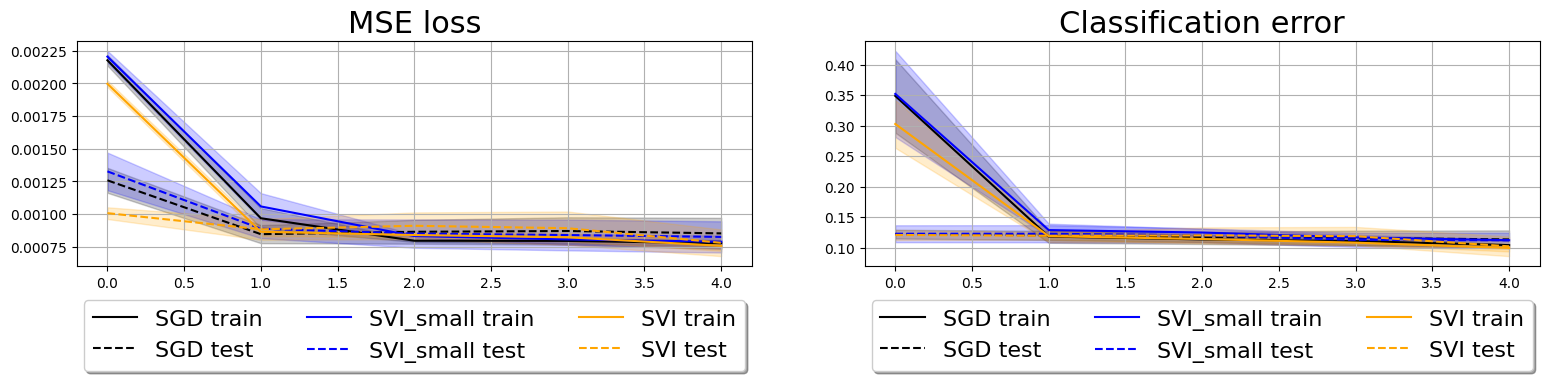

In [17]:
# Visualize results
ave_results_SGD = get_ave_results(results_final_dict_SGD)
ave_results_SVI_old = get_ave_results(results_final_dict_SVI_old)
ave_results_SVI_new = get_ave_results(results_final_dict_SVI_new)


# Plot losses and error
stop = 5
print(f'H = {H}, by epoch {stop} out of {epochs} epochs')
print('####################')
print(f'SGD train loss mean: {ave_results_SGD["train_loss"][stop-1]} +/- {ave_results_SGD["train_loss_std"][stop-1]}')
print(f'SVI_old train loss mean: {ave_results_SVI_old["train_loss"][stop-1]} +/- {ave_results_SVI_old["train_loss_std"][stop-1]}')
print(f'SVI train loss mean: {ave_results_SVI_new["train_loss"][stop-1]} +/- {ave_results_SVI_new["train_loss_std"][stop-1]}')
print('####################')
print(f'SGD test loss mean: {ave_results_SGD["test_loss"][stop-1]} +/- {ave_results_SGD["test_loss_std"][stop-1]}')
print(f'SVI_old test loss mean: {ave_results_SVI_old["test_loss"][stop-1]} +/- {ave_results_SVI_old["test_loss_std"][stop-1]}')
print(f'SVI test loss mean: {ave_results_SVI_new["test_loss"][stop-1]} +/- {ave_results_SVI_new["test_loss_std"][stop-1]}')
print('####################')
print(f'SGD train error mean: {1-ave_results_SGD["train_acc"][stop-1]} +/- {ave_results_SGD["train_acc_std"][stop-1]}')
print(f'SVI_old train error mean: {1-ave_results_SVI_old["train_acc"][stop-1]} +/- {ave_results_SVI_old["train_acc_std"][stop-1]}')
print(f'SVI train error mean: {1-ave_results_SVI_new["train_acc"][stop-1]} +/- {ave_results_SVI_new["train_acc_std"][stop-1]}')
print('####################')
print(f'SGD test error mean: {1-ave_results_SGD["test_acc"][stop-1]} +/- {ave_results_SGD["test_acc_std"][stop-1]}')
print(f'SVI_old test error mean: {1-ave_results_SVI_old["test_acc"][stop-1]} +/- {ave_results_SVI_old["test_acc_std"][stop-1]}')
print(f'SVI test error mean: {1-ave_results_SVI_new["test_acc"][stop-1]} +/- {ave_results_SVI_new["test_acc_std"][stop-1]}')

fig, ax = plt.subplots(1, 2, figsize=(16, 4))
fsize = 22
args = {'ax': ax[0]}
color_labels = {0: ['black', 'SGD'], 1: ['blue', 'SVI_small'], 2: ['orange', 'SVI']}
for i, ave_results in enumerate([ave_results_SGD, ave_results_SVI_old, ave_results_SVI_new]):
    train_key, test_key, suffix = 'train_loss', 'test_loss', '_std'
    args['color'], args['label'] = color_labels[i]
    plot_on_axes(ave_results[train_key][:stop], ave_results[train_key+suffix][:stop],
                 ave_results[test_key][:stop], ave_results[test_key+suffix][:stop],
                 args)
ax[0].set_title('MSE loss', fontsize=fsize)

args = {'ax': ax[1]}
for i, ave_results in enumerate([ave_results_SGD, ave_results_SVI_old, ave_results_SVI_new]):
    train_key, test_key, suffix = 'train_acc', 'test_acc', '_std'
    args['color'], args['label'] = color_labels[i]
    plot_on_axes(1-ave_results[train_key][:stop], ave_results[train_key+suffix][:stop],
                 1-ave_results[test_key][:stop], ave_results[test_key+suffix][:stop],
                 args)
ax[1].set_title('Classification error', fontsize=fsize)

for a in ax.flatten():
    a.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
                fancybox=True, shadow=True, ncol=3, fontsize=fsize-6)
    a.grid()
fig.tight_layout()
plt.show()

H = 64, by epoch 100 out of 100 epochs
####################
SGD train loss mean: 1.20079032300661e-05 +/- 5.218688455829277e-06
SVI_old train loss mean: 0.0002493180241435766 +/- 5.4914742406133256e-05
SVI train loss mean: 2.2432100551668555e-05 +/- 1.7771303646018756e-05
####################
SGD test loss mean: 3.1024761575584605e-05 +/- 9.90532305890522e-06
SVI_old test loss mean: 0.0003129966060320536 +/- 3.2320650463284156e-05
SVI test loss mean: 3.626237737868602e-05 +/- 1.0068322686442307e-05
####################
SGD train error mean: 0.0013333333333332975 +/- 0.0009428090415820641
SVI_old train error mean: 0.026000000000000134 +/- 0.011775681155103806
SVI train error mean: 0.002000000000000113 +/- 0.0016329931618554536
####################
SGD test error mean: 0.002666666666666706 +/- 0.0009428090415820641
SVI_old test error mean: 0.03799999999999992 +/- 0.0043204937989385775
SVI test error mean: 0.004666666666666708 +/- 0.0024944382578492965


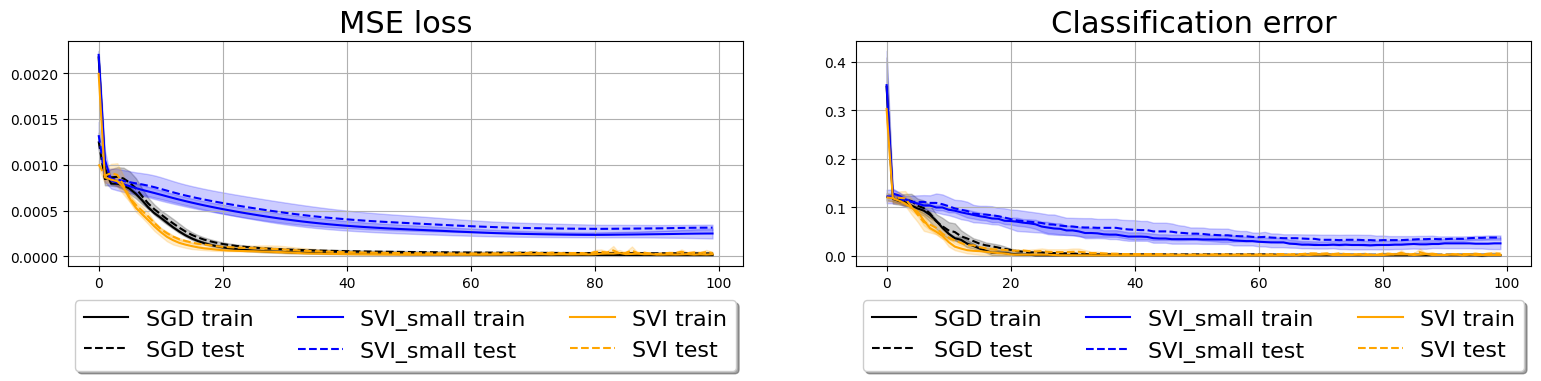

In [18]:
# Visualize results
ave_results_SGD = get_ave_results(results_final_dict_SGD)
ave_results_SVI_old = get_ave_results(results_final_dict_SVI_old)
ave_results_SVI_new = get_ave_results(results_final_dict_SVI_new)


# Plot losses and error
stop = 100
print(f'H = {H}, by epoch {stop} out of {epochs} epochs')
print('####################')
print(f'SGD train loss mean: {ave_results_SGD["train_loss"][stop-1]} +/- {ave_results_SGD["train_loss_std"][stop-1]}')
print(f'SVI_old train loss mean: {ave_results_SVI_old["train_loss"][stop-1]} +/- {ave_results_SVI_old["train_loss_std"][stop-1]}')
print(f'SVI train loss mean: {ave_results_SVI_new["train_loss"][stop-1]} +/- {ave_results_SVI_new["train_loss_std"][stop-1]}')
print('####################')
print(f'SGD test loss mean: {ave_results_SGD["test_loss"][stop-1]} +/- {ave_results_SGD["test_loss_std"][stop-1]}')
print(f'SVI_old test loss mean: {ave_results_SVI_old["test_loss"][stop-1]} +/- {ave_results_SVI_old["test_loss_std"][stop-1]}')
print(f'SVI test loss mean: {ave_results_SVI_new["test_loss"][stop-1]} +/- {ave_results_SVI_new["test_loss_std"][stop-1]}')
print('####################')
print(f'SGD train error mean: {1-ave_results_SGD["train_acc"][stop-1]} +/- {ave_results_SGD["train_acc_std"][stop-1]}')
print(f'SVI_old train error mean: {1-ave_results_SVI_old["train_acc"][stop-1]} +/- {ave_results_SVI_old["train_acc_std"][stop-1]}')
print(f'SVI train error mean: {1-ave_results_SVI_new["train_acc"][stop-1]} +/- {ave_results_SVI_new["train_acc_std"][stop-1]}')
print('####################')
print(f'SGD test error mean: {1-ave_results_SGD["test_acc"][stop-1]} +/- {ave_results_SGD["test_acc_std"][stop-1]}')
print(f'SVI_old test error mean: {1-ave_results_SVI_old["test_acc"][stop-1]} +/- {ave_results_SVI_old["test_acc_std"][stop-1]}')
print(f'SVI test error mean: {1-ave_results_SVI_new["test_acc"][stop-1]} +/- {ave_results_SVI_new["test_acc_std"][stop-1]}')

fig, ax = plt.subplots(1, 2, figsize=(16, 4))
fsize = 22
args = {'ax': ax[0]}
color_labels = {0: ['black', 'SGD'], 1: ['blue', 'SVI_small'], 2: ['orange', 'SVI']}
for i, ave_results in enumerate([ave_results_SGD, ave_results_SVI_old, ave_results_SVI_new]):
    train_key, test_key, suffix = 'train_loss', 'test_loss', '_std'
    args['color'], args['label'] = color_labels[i]
    plot_on_axes(ave_results[train_key][:stop], ave_results[train_key+suffix][:stop],
                 ave_results[test_key][:stop], ave_results[test_key+suffix][:stop],
                 args)
ax[0].set_title('MSE loss', fontsize=fsize)

args = {'ax': ax[1]}
for i, ave_results in enumerate([ave_results_SGD, ave_results_SVI_old, ave_results_SVI_new]):
    train_key, test_key, suffix = 'train_acc', 'test_acc', '_std'
    args['color'], args['label'] = color_labels[i]
    plot_on_axes(1-ave_results[train_key][:stop], ave_results[train_key+suffix][:stop],
                 1-ave_results[test_key][:stop], ave_results[test_key+suffix][:stop],
                 args)
ax[1].set_title('Classification error', fontsize=fsize)

for a in ax.flatten():
    a.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
                fancybox=True, shadow=True, ncol=3, fontsize=fsize-6)
    a.grid()
fig.tight_layout()
plt.show()

### 128 hidden nodes

In [19]:
# Hyperparameters
random_states = [12314,31231224,12341]
H = 128
nlayers = 3
N = 1000
batch_size = int(N/10)
learning_rate = 0.15
momen = 0.9
epochs = 100

In [20]:
# SGD
results_final_dict_SGD = all_together(random_states, SGD = True, nlayers = nlayers)

SGD , H=128, random_state=12314
learning rate= 0.15 , train accuracy= 100.0 %, test accuracy= 99.8 %
training loss = 0.0000, test loss = 0.0000
SGD , H=128, random_state=31231224
learning rate= 0.15 , train accuracy= 99.8 %, test accuracy= 99.8 %
training loss = 0.0000, test loss = 0.0000
SGD , H=128, random_state=12341
learning rate= 0.15 , train accuracy= 100.0 %, test accuracy= 99.8 %
training loss = 0.0000, test loss = 0.0000


In [21]:
# SVI old small scale
results_final_dict_SVI_old = all_together(random_states, SGD = False,
                                          small_prev_layer = True, nlayers = nlayers)

SVI old, H=128, random_state=12314
learning rate= 0.15 , train accuracy= 99.4 %, test accuracy= 99.4 %
training loss = 0.0001, test loss = 0.0001
SVI old, H=128, random_state=31231224
learning rate= 0.15 , train accuracy= 99.6 %, test accuracy= 98.4 %
training loss = 0.0001, test loss = 0.0001
SVI old, H=128, random_state=12341
learning rate= 0.15 , train accuracy= 98.8 %, test accuracy= 95.8 %
training loss = 0.0002, test loss = 0.0003


In [22]:
# SVI new original scale
results_final_dict_SVI_new = all_together(random_states, SGD = False,
                                          small_prev_layer = False, nlayers = nlayers)

SVI new, H=128, random_state=12314
learning rate= 0.15 , train accuracy= 99.8 %, test accuracy= 100.0 %
training loss = 0.0000, test loss = 0.0000
SVI new, H=128, random_state=31231224
learning rate= 0.15 , train accuracy= 99.8 %, test accuracy= 99.6 %
training loss = 0.0000, test loss = 0.0000
SVI new, H=128, random_state=12341
learning rate= 0.15 , train accuracy= 100.0 %, test accuracy= 99.4 %
training loss = 0.0000, test loss = 0.0001


H = 128, by epoch 5 out of 100 epochs
####################
SGD train loss mean: 0.0007234465777873992 +/- 3.433633064626862e-05
SVI_old train loss mean: 0.0008091906880338986 +/- 2.786958096244357e-05
SVI train loss mean: 0.0006399331589539846 +/- 4.11185642068389e-05
####################
SGD test loss mean: 0.0007571192135413488 +/- 0.00014682231958892066
SVI_old test loss mean: 0.0008624109427134196 +/- 0.00012260899638964626
SVI test loss mean: 0.0006444967811306317 +/- 0.00010939241572728245
####################
SGD train error mean: 0.09466666666666657 +/- 0.0037712361663282566
SVI_old train error mean: 0.11399999999999999 +/- 0.007483314773547889
SVI train error mean: 0.09199999999999997 +/- 0.0043204937989385775
####################
SGD test error mean: 0.10199999999999998 +/- 0.01796292478040999
SVI_old test error mean: 0.11399999999999999 +/- 0.012328828005937964
SVI test error mean: 0.07999999999999996 +/- 0.024055491403558282


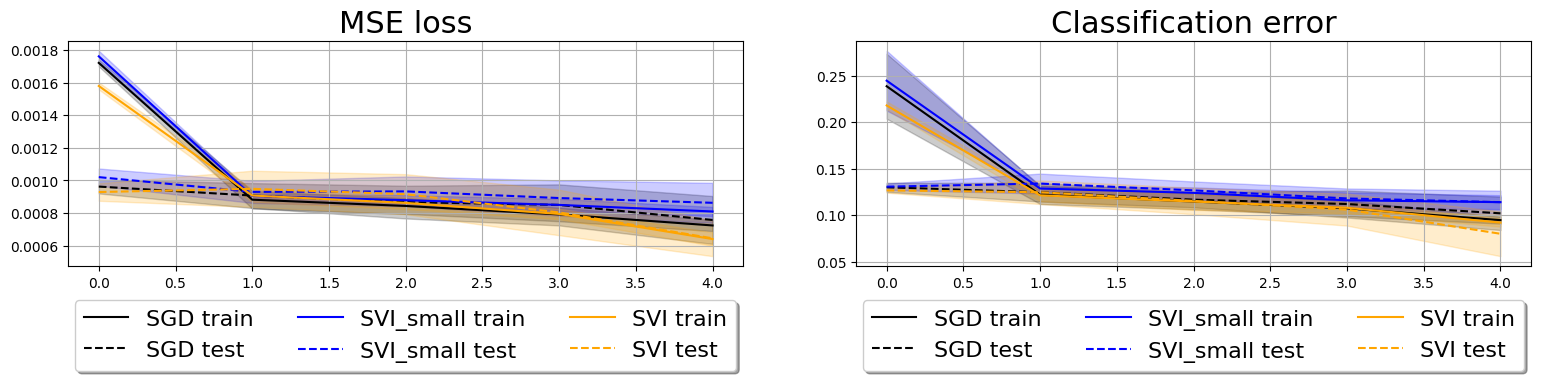

In [23]:
# Visualize results
ave_results_SGD = get_ave_results(results_final_dict_SGD)
ave_results_SVI_old = get_ave_results(results_final_dict_SVI_old)
ave_results_SVI_new = get_ave_results(results_final_dict_SVI_new)


# Plot losses and error
stop = 5
print(f'H = {H}, by epoch {stop} out of {epochs} epochs')
print('####################')
print(f'SGD train loss mean: {ave_results_SGD["train_loss"][stop-1]} +/- {ave_results_SGD["train_loss_std"][stop-1]}')
print(f'SVI_old train loss mean: {ave_results_SVI_old["train_loss"][stop-1]} +/- {ave_results_SVI_old["train_loss_std"][stop-1]}')
print(f'SVI train loss mean: {ave_results_SVI_new["train_loss"][stop-1]} +/- {ave_results_SVI_new["train_loss_std"][stop-1]}')
print('####################')
print(f'SGD test loss mean: {ave_results_SGD["test_loss"][stop-1]} +/- {ave_results_SGD["test_loss_std"][stop-1]}')
print(f'SVI_old test loss mean: {ave_results_SVI_old["test_loss"][stop-1]} +/- {ave_results_SVI_old["test_loss_std"][stop-1]}')
print(f'SVI test loss mean: {ave_results_SVI_new["test_loss"][stop-1]} +/- {ave_results_SVI_new["test_loss_std"][stop-1]}')
print('####################')
print(f'SGD train error mean: {1-ave_results_SGD["train_acc"][stop-1]} +/- {ave_results_SGD["train_acc_std"][stop-1]}')
print(f'SVI_old train error mean: {1-ave_results_SVI_old["train_acc"][stop-1]} +/- {ave_results_SVI_old["train_acc_std"][stop-1]}')
print(f'SVI train error mean: {1-ave_results_SVI_new["train_acc"][stop-1]} +/- {ave_results_SVI_new["train_acc_std"][stop-1]}')
print('####################')
print(f'SGD test error mean: {1-ave_results_SGD["test_acc"][stop-1]} +/- {ave_results_SGD["test_acc_std"][stop-1]}')
print(f'SVI_old test error mean: {1-ave_results_SVI_old["test_acc"][stop-1]} +/- {ave_results_SVI_old["test_acc_std"][stop-1]}')
print(f'SVI test error mean: {1-ave_results_SVI_new["test_acc"][stop-1]} +/- {ave_results_SVI_new["test_acc_std"][stop-1]}')

fig, ax = plt.subplots(1, 2, figsize=(16, 4))
fsize = 22
args = {'ax': ax[0]}
color_labels = {0: ['black', 'SGD'], 1: ['blue', 'SVI_small'], 2: ['orange', 'SVI']}
for i, ave_results in enumerate([ave_results_SGD, ave_results_SVI_old, ave_results_SVI_new]):
    train_key, test_key, suffix = 'train_loss', 'test_loss', '_std'
    args['color'], args['label'] = color_labels[i]
    plot_on_axes(ave_results[train_key][:stop], ave_results[train_key+suffix][:stop],
                 ave_results[test_key][:stop], ave_results[test_key+suffix][:stop],
                 args)
ax[0].set_title('MSE loss', fontsize=fsize)

args = {'ax': ax[1]}
for i, ave_results in enumerate([ave_results_SGD, ave_results_SVI_old, ave_results_SVI_new]):
    train_key, test_key, suffix = 'train_acc', 'test_acc', '_std'
    args['color'], args['label'] = color_labels[i]
    plot_on_axes(1-ave_results[train_key][:stop], ave_results[train_key+suffix][:stop],
                 1-ave_results[test_key][:stop], ave_results[test_key+suffix][:stop],
                 args)
ax[1].set_title('Classification error', fontsize=fsize)

for a in ax.flatten():
    a.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
                fancybox=True, shadow=True, ncol=3, fontsize=fsize-6)
    a.grid()
fig.tight_layout()
plt.show()

H = 128, by epoch 100 out of 100 epochs
####################
SGD train loss mean: 9.341249494658161e-06 +/- 5.275741239164856e-06
SVI_old train loss mean: 0.00011302896061291297 +/- 3.384800348516482e-05
SVI train loss mean: 1.600459810773221e-05 +/- 1.0560459440941147e-05
####################
SGD test loss mean: 2.1729631776300567e-05 +/- 4.976167137241655e-06
SVI_old test loss mean: 0.0001774081190427144 +/- 9.712195218316335e-05
SVI test loss mean: 3.183606353938254e-05 +/- 1.963722395298136e-05
####################
SGD train error mean: 0.0006666666666665932 +/- 0.0009428090415820641
SVI_old train error mean: 0.007333333333333414 +/- 0.003399346342395193
SVI train error mean: 0.0013333333333332975 +/- 0.0009428090415820641
####################
SGD test error mean: 0.002000000000000113 +/- 1.1102230246251565e-16
SVI_old test error mean: 0.021333333333333315 +/- 0.01517307556898807
SVI test error mean: 0.0033333333333332993 +/- 0.0024944382578492965


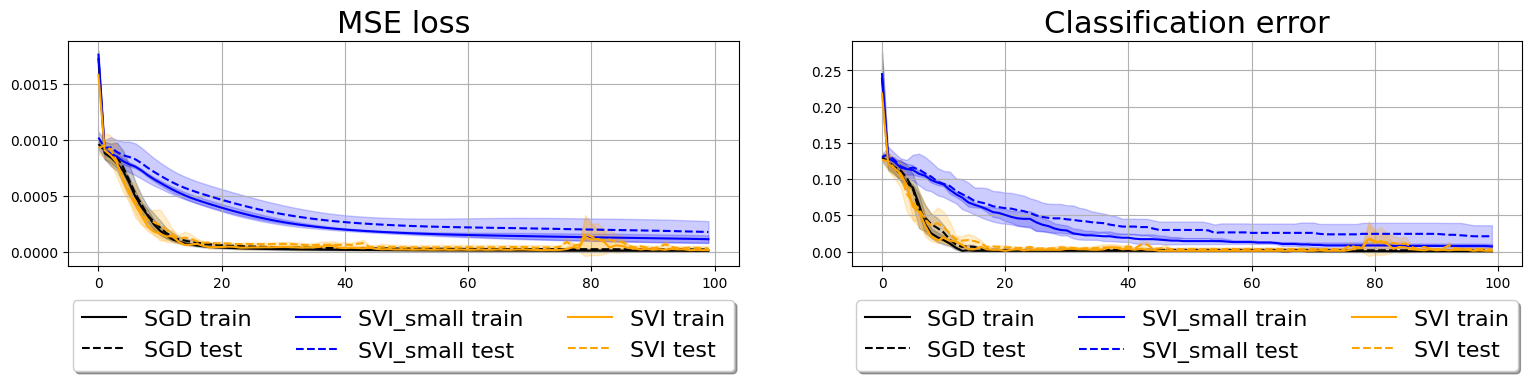

In [24]:
# Visualize results
ave_results_SGD = get_ave_results(results_final_dict_SGD)
ave_results_SVI_old = get_ave_results(results_final_dict_SVI_old)
ave_results_SVI_new = get_ave_results(results_final_dict_SVI_new)


# Plot losses and error
stop = 100
print(f'H = {H}, by epoch {stop} out of {epochs} epochs')
print('####################')
print(f'SGD train loss mean: {ave_results_SGD["train_loss"][stop-1]} +/- {ave_results_SGD["train_loss_std"][stop-1]}')
print(f'SVI_old train loss mean: {ave_results_SVI_old["train_loss"][stop-1]} +/- {ave_results_SVI_old["train_loss_std"][stop-1]}')
print(f'SVI train loss mean: {ave_results_SVI_new["train_loss"][stop-1]} +/- {ave_results_SVI_new["train_loss_std"][stop-1]}')
print('####################')
print(f'SGD test loss mean: {ave_results_SGD["test_loss"][stop-1]} +/- {ave_results_SGD["test_loss_std"][stop-1]}')
print(f'SVI_old test loss mean: {ave_results_SVI_old["test_loss"][stop-1]} +/- {ave_results_SVI_old["test_loss_std"][stop-1]}')
print(f'SVI test loss mean: {ave_results_SVI_new["test_loss"][stop-1]} +/- {ave_results_SVI_new["test_loss_std"][stop-1]}')
print('####################')
print(f'SGD train error mean: {1-ave_results_SGD["train_acc"][stop-1]} +/- {ave_results_SGD["train_acc_std"][stop-1]}')
print(f'SVI_old train error mean: {1-ave_results_SVI_old["train_acc"][stop-1]} +/- {ave_results_SVI_old["train_acc_std"][stop-1]}')
print(f'SVI train error mean: {1-ave_results_SVI_new["train_acc"][stop-1]} +/- {ave_results_SVI_new["train_acc_std"][stop-1]}')
print('####################')
print(f'SGD test error mean: {1-ave_results_SGD["test_acc"][stop-1]} +/- {ave_results_SGD["test_acc_std"][stop-1]}')
print(f'SVI_old test error mean: {1-ave_results_SVI_old["test_acc"][stop-1]} +/- {ave_results_SVI_old["test_acc_std"][stop-1]}')
print(f'SVI test error mean: {1-ave_results_SVI_new["test_acc"][stop-1]} +/- {ave_results_SVI_new["test_acc_std"][stop-1]}')

fig, ax = plt.subplots(1, 2, figsize=(16, 4))
fsize = 22
args = {'ax': ax[0]}
color_labels = {0: ['black', 'SGD'], 1: ['blue', 'SVI_small'], 2: ['orange', 'SVI']}
for i, ave_results in enumerate([ave_results_SGD, ave_results_SVI_old, ave_results_SVI_new]):
    train_key, test_key, suffix = 'train_loss', 'test_loss', '_std'
    args['color'], args['label'] = color_labels[i]
    plot_on_axes(ave_results[train_key][:stop], ave_results[train_key+suffix][:stop],
                 ave_results[test_key][:stop], ave_results[test_key+suffix][:stop],
                 args)
ax[0].set_title('MSE loss', fontsize=fsize)

args = {'ax': ax[1]}
for i, ave_results in enumerate([ave_results_SGD, ave_results_SVI_old, ave_results_SVI_new]):
    train_key, test_key, suffix = 'train_acc', 'test_acc', '_std'
    args['color'], args['label'] = color_labels[i]
    plot_on_axes(1-ave_results[train_key][:stop], ave_results[train_key+suffix][:stop],
                 1-ave_results[test_key][:stop], ave_results[test_key+suffix][:stop],
                 args)
ax[1].set_title('Classification error', fontsize=fsize)

for a in ax.flatten():
    a.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
                fancybox=True, shadow=True, ncol=3, fontsize=fsize-6)
    a.grid()
fig.tight_layout()
plt.show()

### 256 hidden nodes

In [26]:
# Hyperparameters
random_states = [12314,31231224,12341]
H = 256
nlayers = 3
N = 1000
batch_size = int(N/10)
learning_rate = 0.15
momen = 0.9
epochs = 100

In [27]:
# SGD
results_final_dict_SGD = all_together(random_states, SGD = True, nlayers = nlayers)

SGD , H=256, random_state=12314
learning rate= 0.15 , train accuracy= 100.0 %, test accuracy= 99.8 %
training loss = 0.0000, test loss = 0.0000
SGD , H=256, random_state=31231224
learning rate= 0.15 , train accuracy= 99.8 %, test accuracy= 99.8 %
training loss = 0.0000, test loss = 0.0000
SGD , H=256, random_state=12341
learning rate= 0.15 , train accuracy= 100.0 %, test accuracy= 99.8 %
training loss = 0.0000, test loss = 0.0000


In [28]:
# SVI old small scale
results_final_dict_SVI_old = all_together(random_states, SGD = False,
                                          small_prev_layer = True, nlayers = nlayers)

SVI old, H=256, random_state=12314
learning rate= 0.15 , train accuracy= 99.4 %, test accuracy= 98.4 %
training loss = 0.0001, test loss = 0.0001
SVI old, H=256, random_state=31231224
learning rate= 0.15 , train accuracy= 99.2 %, test accuracy= 98.8 %
training loss = 0.0001, test loss = 0.0001
SVI old, H=256, random_state=12341
learning rate= 0.15 , train accuracy= 100.0 %, test accuracy= 99.2 %
training loss = 0.0000, test loss = 0.0001


In [29]:
# SVI new original scale
results_final_dict_SVI_new = all_together(random_states, SGD = False,
                                          small_prev_layer = False, nlayers = nlayers)

SVI new, H=256, random_state=12314
learning rate= 0.15 , train accuracy= 99.4 %, test accuracy= 100.0 %
training loss = 0.0000, test loss = 0.0000
SVI new, H=256, random_state=31231224
learning rate= 0.15 , train accuracy= 99.8 %, test accuracy= 99.4 %
training loss = 0.0000, test loss = 0.0000
SVI new, H=256, random_state=12341
learning rate= 0.15 , train accuracy= 100.0 %, test accuracy= 99.6 %
training loss = 0.0000, test loss = 0.0000


H = 256, by epoch 5 out of 100 epochs
####################
SGD train loss mean: 0.0005979643315076827 +/- 2.4121354350987387e-05
SVI_old train loss mean: 0.000760663077235222 +/- 8.773067855022347e-06
SVI train loss mean: 0.0005083847219745319 +/- 4.350361536768264e-05
####################
SGD test loss mean: 0.0005825059997538726 +/- 0.00013753515773908616
SVI_old test loss mean: 0.0008120157172282536 +/- 0.00013859193557257373
SVI test loss mean: 0.000503470603376627 +/- 9.878686151249799e-05
####################
SGD train error mean: 0.08333333333333337 +/- 0.0024944382578492965
SVI_old train error mean: 0.10066666666666668 +/- 0.0037712361663282566
SVI train error mean: 0.061999999999999944 +/- 0.00748331477354784
####################
SGD test error mean: 0.07399999999999995 +/- 0.021969676071045423
SVI_old test error mean: 0.10799999999999998 +/- 0.023551362310207612
SVI test error mean: 0.06400000000000006 +/- 0.015577761927397196


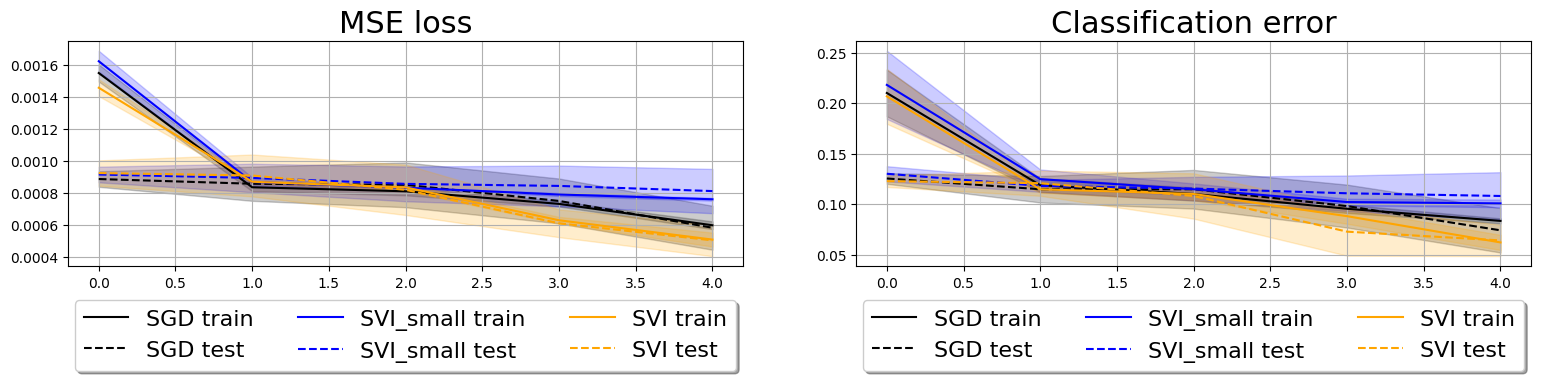

In [30]:
# Visualize results
ave_results_SGD = get_ave_results(results_final_dict_SGD)
ave_results_SVI_old = get_ave_results(results_final_dict_SVI_old)
ave_results_SVI_new = get_ave_results(results_final_dict_SVI_new)


# Plot losses and error
stop = 5
print(f'H = {H}, by epoch {stop} out of {epochs} epochs')
print('####################')
print(f'SGD train loss mean: {ave_results_SGD["train_loss"][stop-1]} +/- {ave_results_SGD["train_loss_std"][stop-1]}')
print(f'SVI_old train loss mean: {ave_results_SVI_old["train_loss"][stop-1]} +/- {ave_results_SVI_old["train_loss_std"][stop-1]}')
print(f'SVI train loss mean: {ave_results_SVI_new["train_loss"][stop-1]} +/- {ave_results_SVI_new["train_loss_std"][stop-1]}')
print('####################')
print(f'SGD test loss mean: {ave_results_SGD["test_loss"][stop-1]} +/- {ave_results_SGD["test_loss_std"][stop-1]}')
print(f'SVI_old test loss mean: {ave_results_SVI_old["test_loss"][stop-1]} +/- {ave_results_SVI_old["test_loss_std"][stop-1]}')
print(f'SVI test loss mean: {ave_results_SVI_new["test_loss"][stop-1]} +/- {ave_results_SVI_new["test_loss_std"][stop-1]}')
print('####################')
print(f'SGD train error mean: {1-ave_results_SGD["train_acc"][stop-1]} +/- {ave_results_SGD["train_acc_std"][stop-1]}')
print(f'SVI_old train error mean: {1-ave_results_SVI_old["train_acc"][stop-1]} +/- {ave_results_SVI_old["train_acc_std"][stop-1]}')
print(f'SVI train error mean: {1-ave_results_SVI_new["train_acc"][stop-1]} +/- {ave_results_SVI_new["train_acc_std"][stop-1]}')
print('####################')
print(f'SGD test error mean: {1-ave_results_SGD["test_acc"][stop-1]} +/- {ave_results_SGD["test_acc_std"][stop-1]}')
print(f'SVI_old test error mean: {1-ave_results_SVI_old["test_acc"][stop-1]} +/- {ave_results_SVI_old["test_acc_std"][stop-1]}')
print(f'SVI test error mean: {1-ave_results_SVI_new["test_acc"][stop-1]} +/- {ave_results_SVI_new["test_acc_std"][stop-1]}')

fig, ax = plt.subplots(1, 2, figsize=(16, 4))
fsize = 22
args = {'ax': ax[0]}
color_labels = {0: ['black', 'SGD'], 1: ['blue', 'SVI_small'], 2: ['orange', 'SVI']}
for i, ave_results in enumerate([ave_results_SGD, ave_results_SVI_old, ave_results_SVI_new]):
    train_key, test_key, suffix = 'train_loss', 'test_loss', '_std'
    args['color'], args['label'] = color_labels[i]
    plot_on_axes(ave_results[train_key][:stop], ave_results[train_key+suffix][:stop],
                 ave_results[test_key][:stop], ave_results[test_key+suffix][:stop],
                 args)
ax[0].set_title('MSE loss', fontsize=fsize)

args = {'ax': ax[1]}
for i, ave_results in enumerate([ave_results_SGD, ave_results_SVI_old, ave_results_SVI_new]):
    train_key, test_key, suffix = 'train_acc', 'test_acc', '_std'
    args['color'], args['label'] = color_labels[i]
    plot_on_axes(1-ave_results[train_key][:stop], ave_results[train_key+suffix][:stop],
                 1-ave_results[test_key][:stop], ave_results[test_key+suffix][:stop],
                 args)
ax[1].set_title('Classification error', fontsize=fsize)

for a in ax.flatten():
    a.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
                fancybox=True, shadow=True, ncol=3, fontsize=fsize-6)
    a.grid()
fig.tight_layout()
plt.show()

H = 256, by epoch 100 out of 100 epochs
####################
SGD train loss mean: 6.351324157246077e-06 +/- 3.954486751989422e-06
SVI_old train loss mean: 9.081767421836652e-05 +/- 5.469870520285902e-05
SVI train loss mean: 2.1862428293388804e-05 +/- 1.817417925226174e-05
####################
SGD test loss mean: 1.9803987338188258e-05 +/- 5.5946199811866515e-06
SVI_old test loss mean: 0.00012196375615894794 +/- 3.005117744713949e-05
SVI test loss mean: 2.501779062004061e-05 +/- 1.3254241620872018e-05
####################
SGD train error mean: 0.0006666666666665932 +/- 0.0009428090415820641
SVI_old train error mean: 0.004666666666666708 +/- 0.003399346342395193
SVI train error mean: 0.002666666666666706 +/- 0.0024944382578492965
####################
SGD test error mean: 0.002000000000000113 +/- 1.1102230246251565e-16
SVI_old test error mean: 0.01200000000000001 +/- 0.0032659863237109073
SVI test error mean: 0.0033333333333332993 +/- 0.0024944382578492965


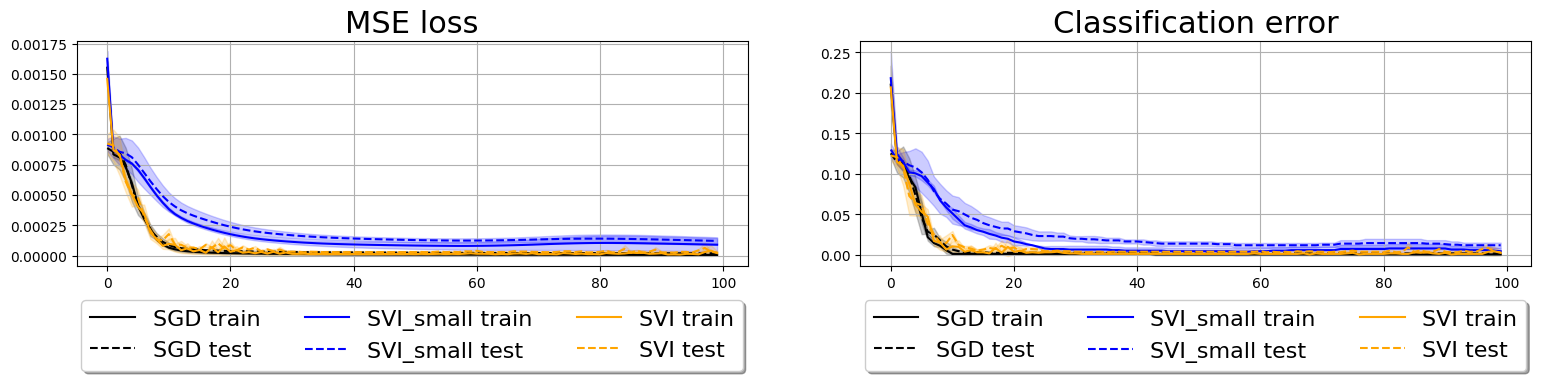

In [31]:
# Visualize results
ave_results_SGD = get_ave_results(results_final_dict_SGD)
ave_results_SVI_old = get_ave_results(results_final_dict_SVI_old)
ave_results_SVI_new = get_ave_results(results_final_dict_SVI_new)


# Plot losses and error
stop = 100
print(f'H = {H}, by epoch {stop} out of {epochs} epochs')
print('####################')
print(f'SGD train loss mean: {ave_results_SGD["train_loss"][stop-1]} +/- {ave_results_SGD["train_loss_std"][stop-1]}')
print(f'SVI_old train loss mean: {ave_results_SVI_old["train_loss"][stop-1]} +/- {ave_results_SVI_old["train_loss_std"][stop-1]}')
print(f'SVI train loss mean: {ave_results_SVI_new["train_loss"][stop-1]} +/- {ave_results_SVI_new["train_loss_std"][stop-1]}')
print('####################')
print(f'SGD test loss mean: {ave_results_SGD["test_loss"][stop-1]} +/- {ave_results_SGD["test_loss_std"][stop-1]}')
print(f'SVI_old test loss mean: {ave_results_SVI_old["test_loss"][stop-1]} +/- {ave_results_SVI_old["test_loss_std"][stop-1]}')
print(f'SVI test loss mean: {ave_results_SVI_new["test_loss"][stop-1]} +/- {ave_results_SVI_new["test_loss_std"][stop-1]}')
print('####################')
print(f'SGD train error mean: {1-ave_results_SGD["train_acc"][stop-1]} +/- {ave_results_SGD["train_acc_std"][stop-1]}')
print(f'SVI_old train error mean: {1-ave_results_SVI_old["train_acc"][stop-1]} +/- {ave_results_SVI_old["train_acc_std"][stop-1]}')
print(f'SVI train error mean: {1-ave_results_SVI_new["train_acc"][stop-1]} +/- {ave_results_SVI_new["train_acc_std"][stop-1]}')
print('####################')
print(f'SGD test error mean: {1-ave_results_SGD["test_acc"][stop-1]} +/- {ave_results_SGD["test_acc_std"][stop-1]}')
print(f'SVI_old test error mean: {1-ave_results_SVI_old["test_acc"][stop-1]} +/- {ave_results_SVI_old["test_acc_std"][stop-1]}')
print(f'SVI test error mean: {1-ave_results_SVI_new["test_acc"][stop-1]} +/- {ave_results_SVI_new["test_acc_std"][stop-1]}')

fig, ax = plt.subplots(1, 2, figsize=(16, 4))
fsize = 22
args = {'ax': ax[0]}
color_labels = {0: ['black', 'SGD'], 1: ['blue', 'SVI_small'], 2: ['orange', 'SVI']}
for i, ave_results in enumerate([ave_results_SGD, ave_results_SVI_old, ave_results_SVI_new]):
    train_key, test_key, suffix = 'train_loss', 'test_loss', '_std'
    args['color'], args['label'] = color_labels[i]
    plot_on_axes(ave_results[train_key][:stop], ave_results[train_key+suffix][:stop],
                 ave_results[test_key][:stop], ave_results[test_key+suffix][:stop],
                 args)
ax[0].set_title('MSE loss', fontsize=fsize)

args = {'ax': ax[1]}
for i, ave_results in enumerate([ave_results_SGD, ave_results_SVI_old, ave_results_SVI_new]):
    train_key, test_key, suffix = 'train_acc', 'test_acc', '_std'
    args['color'], args['label'] = color_labels[i]
    plot_on_axes(1-ave_results[train_key][:stop], ave_results[train_key+suffix][:stop],
                 1-ave_results[test_key][:stop], ave_results[test_key+suffix][:stop],
                 args)
ax[1].set_title('Classification error', fontsize=fsize)

for a in ax.flatten():
    a.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
                fancybox=True, shadow=True, ncol=3, fontsize=fsize-6)
    a.grid()
fig.tight_layout()
plt.show()